In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.svm import SVC


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')


In [263]:
data = pd.read_json('humset_bias_train_en_no_long.jsonl', lines=True)

data['subpillars_labels'] = data['subpillars'].apply(lambda x: "~".join(x))

data.head(5)

id                                               text  \
0  199921  with over one million IDPs inside Burkina Faso...   
1  293791  Highly vulnerable regions like Africa need at ...   
2  169537  The deterioration of the security situation ha...   
3  155848  To date, UNHCR and its partner the Fondation H...   
4  158303  "We're seeing an alarming deterioration in foo...   

                                          subpillars  \
0             [Displacement->Type/numbers/movements]   
1           [Context->Environment, Context->Economy]   
2  [Displacement->Push factors, Context->Security...   
3  [Capacities & response->International response...   
4  [Humanitarian conditions->Living standards, Di...   

                                   subpillars_labels  
0               Displacement->Type/numbers/movements  
1              Context->Environment~Context->Economy  
2  Displacement->Push factors~Context->Security &...  
3  Capacities & response->International response~...  
4  Humanitarian conditions->Living standards~Disp...

In [264]:
all_topics = set(topic for topics in data['subpillars'] for topic in topics)

# Create text-topic pairs with binary labels
rows = []
for _, row in data.iterrows():
    for topic in all_topics:
        rows.append({
            "text": row['text'],
            "topic": topic,
            "label": 1 if topic in row['subpillars'] else 0
        })

binary_df = pd.DataFrame(rows)

label_0_rows = binary_df[binary_df['label'] == 0]
label_1_rows = binary_df[binary_df['label'] == 1]

label_0_sampled = label_0_rows.sample(frac=0.03, random_state=42)

reduced_binary_df = pd.concat([label_0_sampled, label_1_rows])

reduced_binary_df = reduced_binary_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [265]:
len(reduced_binary_df)

272237

In [266]:
unique_texts = reduced_binary_df['text'].unique().tolist()
unique_topics = reduced_binary_df['topic'].unique().tolist()

text_embeddings = model.encode(unique_texts, show_progress_bar=True)
topic_embeddings = model.encode(unique_topics, show_progress_bar=True)

Batches:   0%|          | 0/2621 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [267]:
text_to_emb = {txt: emb for txt, emb in zip(unique_texts, text_embeddings)}
topic_to_emb = {tpc: emb for tpc, emb in zip(unique_topics, topic_embeddings)}

In [268]:
text_emb_list = []
topic_emb_list = []
for idx, row in reduced_binary_df.iterrows():
    t_emb = text_to_emb[row['text']]
    p_emb = topic_to_emb[row['topic']]
    text_emb_list.append(t_emb)
    topic_emb_list.append(p_emb)

In [269]:
reduced_binary_df['text_embedding'] = text_emb_list
reduced_binary_df['topic_embedding'] = topic_emb_list
reduced_binary_df['embedding_concat'] = reduced_binary_df.apply(
    lambda row: np.concatenate([row['text_embedding'], row['topic_embedding']]),
    axis=1
)

## Train

In [11]:
X = np.vstack(reduced_binary_df['embedding_concat'].values)
y = reduced_binary_df['label'].values

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
clf = SVC(kernel='rbf', random_state=42, verbose=1)

In [13]:
clf.fit(X_train, y_train)

[LibSVM]......................................*..............*
optimization finished, #iter = 52950
obj = -23330.726938, rho = -1.041986
nSV = 33428, nBSV = 24972
Total nSV = 33428


SVC(random_state=42, verbose=1)

In [261]:
accuracy = clf.score(X_test, y_test)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9009287925696594


## Test

In [207]:
test_data = pd.read_json('humset_bias_test_en_no_long.jsonl', lines=True)

test_data['subpillars_labels'] = test_data['subpillars'].apply(lambda x: "~".join(x))

test_data.head(5)

id                                               text  \
0  158988               Refugees in Burkina Faso  ( 19,900 )   
1  151839  In Boucle du Mouhoun – the region that produce...   
2  169532  UNHCR also provided in kind donations, compose...   
3  198541  The lack of training has left these volunteer ...   
4  200789  An analysis of COVID 19 and non COVID requirem...   

                                          subpillars  \
0             [Displacement->Type/numbers/movements]   
1  [Context->Security & stability, Impact->Driver...   
2  [Capacities & response->International response...   
3                    [Context->Security & stability]   
4  [Capacities & response->People reached/respons...   

                                   subpillars_labels  
0               Displacement->Type/numbers/movements  
1  Context->Security & stability~Impact->Driver/a...  
2  Capacities & response->International response~...  
3                      Context->Security & stability  
4  Capacities & response->People reached/response...

In [ ]:
all_topics = set(topic for topics in test_data['subpillars'] for topic in topics)

rows = []
for _, row in test_data.iterrows():
    for topic in all_topics:
        rows.append({
            "text": row['text'],
            "topic": topic,
            "label": 1 if topic in row['subpillars'] else 0
        })

binary_df = pd.DataFrame(rows)

label_0_rows = binary_df[binary_df['label'] == 0]
label_1_rows = binary_df[binary_df['label'] == 1]

label_0_sampled = label_0_rows.sample(frac=1, random_state=42)

reduced_binary_df = pd.concat([label_0_sampled, label_1_rows])

reduced_binary_df = reduced_binary_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [211]:
unique_texts = reduced_binary_df['text'].unique().tolist()
unique_topics = reduced_binary_df['topic'].unique().tolist()

text_embeddings = model.encode(unique_texts, show_progress_bar=True)
topic_embeddings = model.encode(unique_topics, show_progress_bar=True)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [212]:
text_to_emb = {txt: emb for txt, emb in zip(unique_texts, text_embeddings)}
topic_to_emb = {tpc: emb for tpc, emb in zip(unique_topics, topic_embeddings)}

In [213]:
text_emb_list = []
topic_emb_list = []
for idx, row in reduced_binary_df.iterrows():
    t_emb = text_to_emb[row['text']]
    p_emb = topic_to_emb[row['topic']]
    text_emb_list.append(t_emb)
    topic_emb_list.append(p_emb)

In [214]:
reduced_binary_df['text_embedding'] = text_emb_list
reduced_binary_df['topic_embedding'] = topic_emb_list
reduced_binary_df['embedding_concat'] = reduced_binary_df.apply(
    lambda row: np.concatenate([row['text_embedding'], row['topic_embedding']]),
    axis=1
)

In [215]:
X = np.vstack(reduced_binary_df['embedding_concat'].values)
y = reduced_binary_df['label'].values

In [ ]:
labels_dict = dict()
pred_dict = dict()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

results = []

for threshold in [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9]:
    decision_scores = clf.decision_function(X)

    logits = decision_scores
    probabilities = sigmoid(logits)
    y_pred = (probabilities > threshold).astype(int)
    reduced_binary_df["y_pred"] = y_pred

    sorted_df = reduced_binary_df.sort_values(by='topic')

    labels_dict = dict()
    pred_dict = dict()

    for idx, row in sorted_df.iterrows():
        labels_ls = labels_dict.get(row["text"], [])
        pred_ls = pred_dict.get(row["text"], [])
        if len(labels_ls) == 0:
            labels_dict[row["text"]] = [row["label"]]
            pred_dict[row["text"]] = [row["y_pred"]]
        else:
            labels_ls.append(row["label"])
            pred_ls.append(row["y_pred"])
            labels_dict[row["text"]] = labels_ls
            pred_dict[row["text"]] = pred_ls

    all_labels = np.array(list(labels_dict.values())).flatten()
    all_predictions = np.array(list(pred_dict.values())).flatten()

    f1_micro = f1_score(all_labels, all_predictions, average="micro")
    f1_macro = f1_score(all_labels, all_predictions, average="macro")
    precision_micro = precision_score(all_labels, all_predictions, average="micro")
    precision_macro = precision_score(all_labels, all_predictions, average="macro")
    recall_micro = recall_score(all_labels, all_predictions, average="micro")
    recall_macro = recall_score(all_labels, all_predictions, average="macro")

    results.append({
        "Threshold": threshold,
        "F1 Micro": f1_micro,
        "F1 Macro": f1_macro,
        "Precision Micro": precision_micro,
        "Precision Macro": precision_macro,
        "Recall Micro": recall_micro,
        "Recall Macro": recall_macro
    })

results_df = pd.DataFrame(results)
results_df

Threshold  F1 Micro  F1 Macro  Precision Micro  Precision Macro  \
0       0.50  0.808929  0.606196         0.808929         0.595762   
1       0.60  0.867857  0.659647         0.867857         0.623197   
2       0.65  0.901071  0.695293         0.901071         0.647983   
3       0.70  0.925357  0.716691         0.925357         0.672305   
4       0.75  0.943214  0.727693         0.943214         0.706227   
5       0.80  0.955714  0.716529         0.955714         0.770026   
6       0.90  0.953214  0.536269         0.953214         0.914219   

   Recall Micro  Recall Macro  
0      0.808929      0.868392  
1      0.867857      0.871678  
2      0.901071      0.857982  
3      0.925357      0.811898  
4      0.943214      0.755510  
5      0.955714      0.682458  
6      0.953214      0.525360

In [26]:
import joblib

joblib.dump(clf, "trained_svc_model.pkl")


['trained_svc_model.pkl']

## Visualise

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/_8/2rwb4tb52wd4mhc0wm29v54m0000gn/T/ipykernel_40023/929320104.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


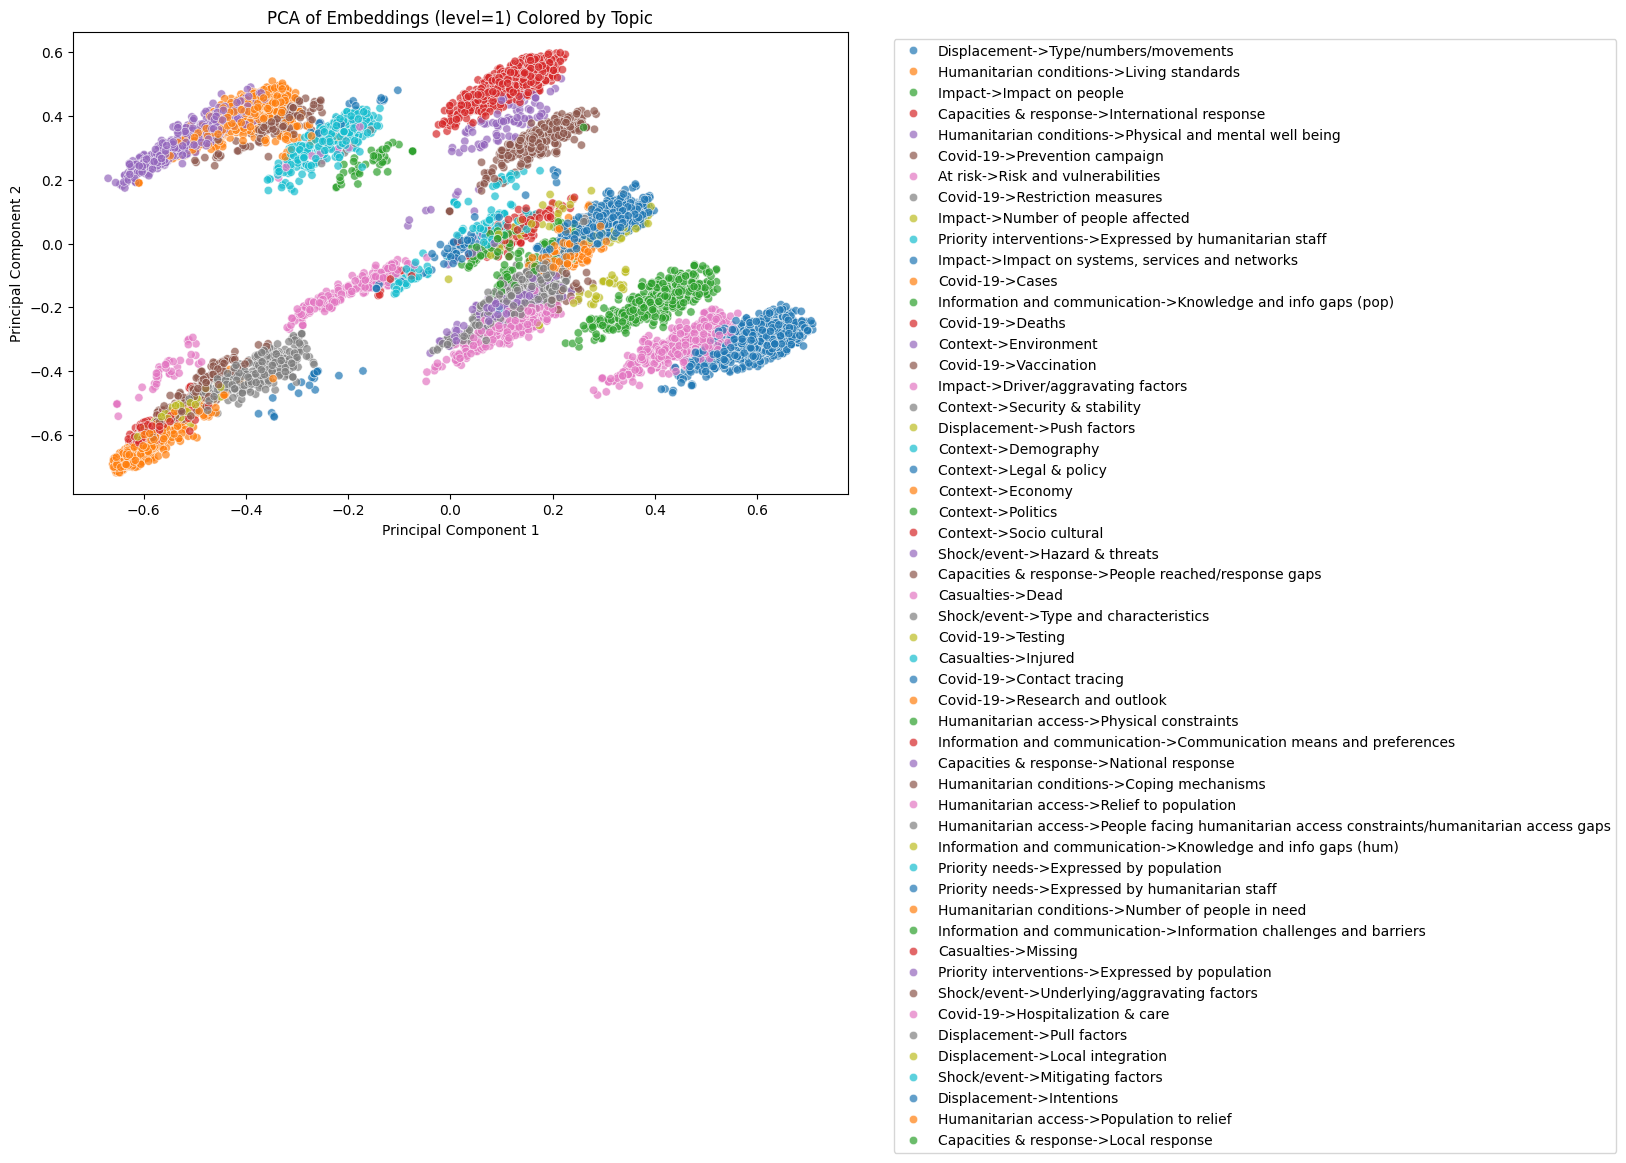

In [54]:
# Filter the DataFrame to include only rows where level = 1
filtered_df = reduced_binary_df[reduced_binary_df["label"] == 1]

# Extract X and topics from the filtered DataFrame
X_filtered = np.vstack(filtered_df['embedding_concat'].values)
topics_filtered = filtered_df['topic'].values

# Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca_filtered = pca.fit_transform(X_filtered)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': X_pca_filtered[:, 0],
    'PC2': X_pca_filtered[:, 1],
    'topic': topics_filtered
})

# Set up the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='topic', palette='tab10', alpha=0.7)

plt.title("PCA of Embeddings (level=1) Colored by Topic")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


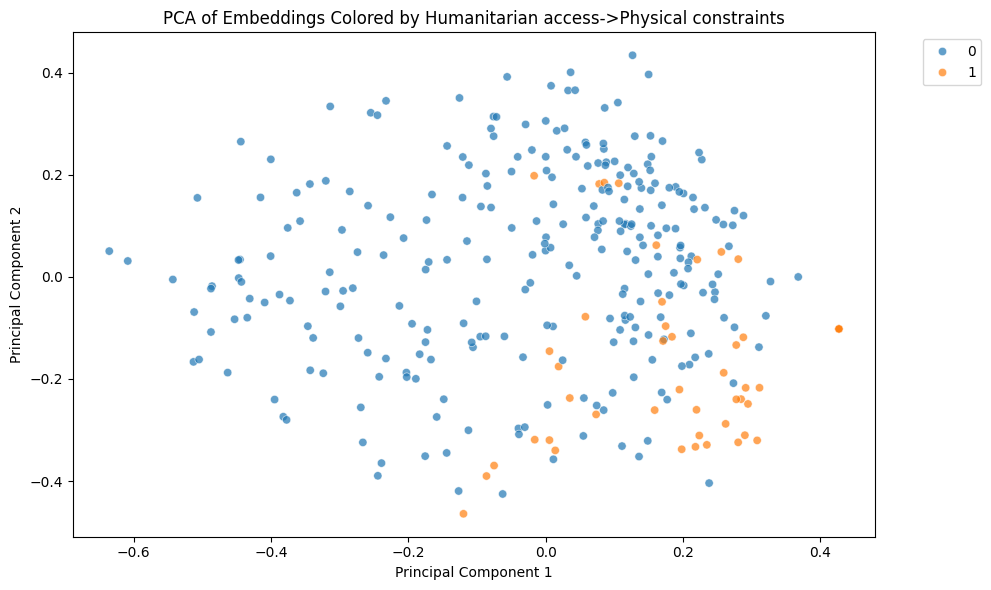

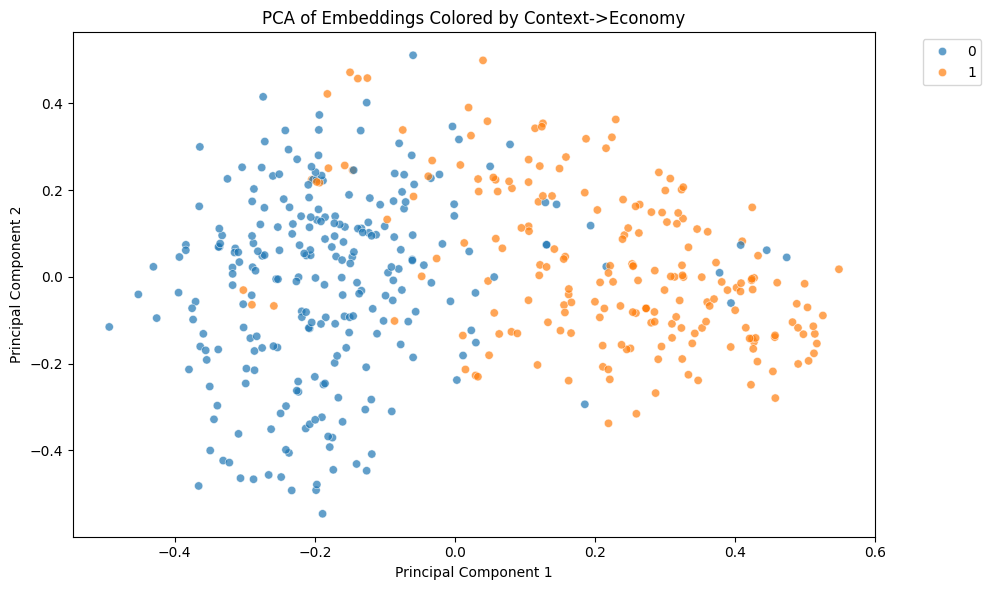

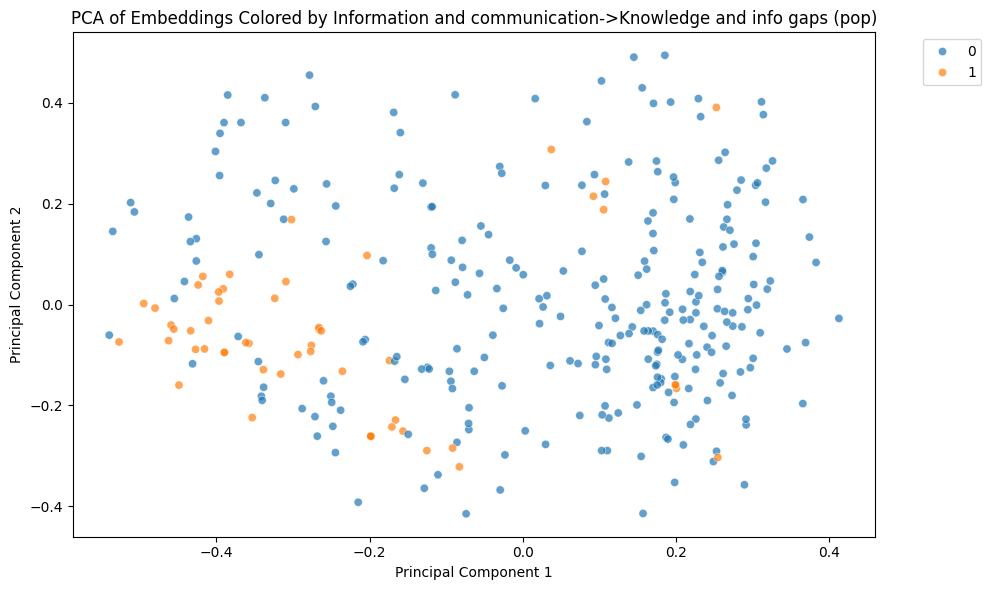

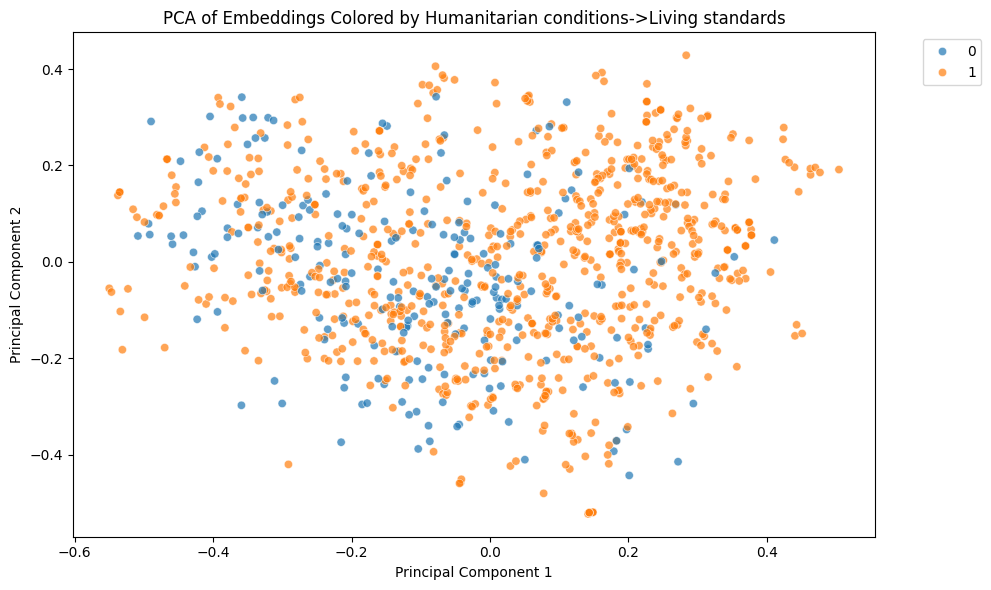

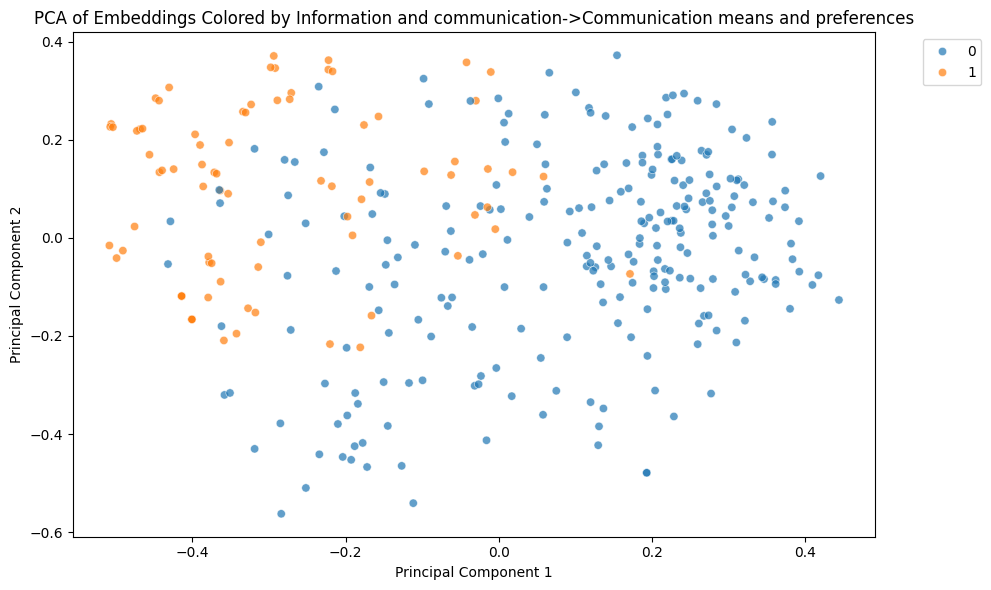

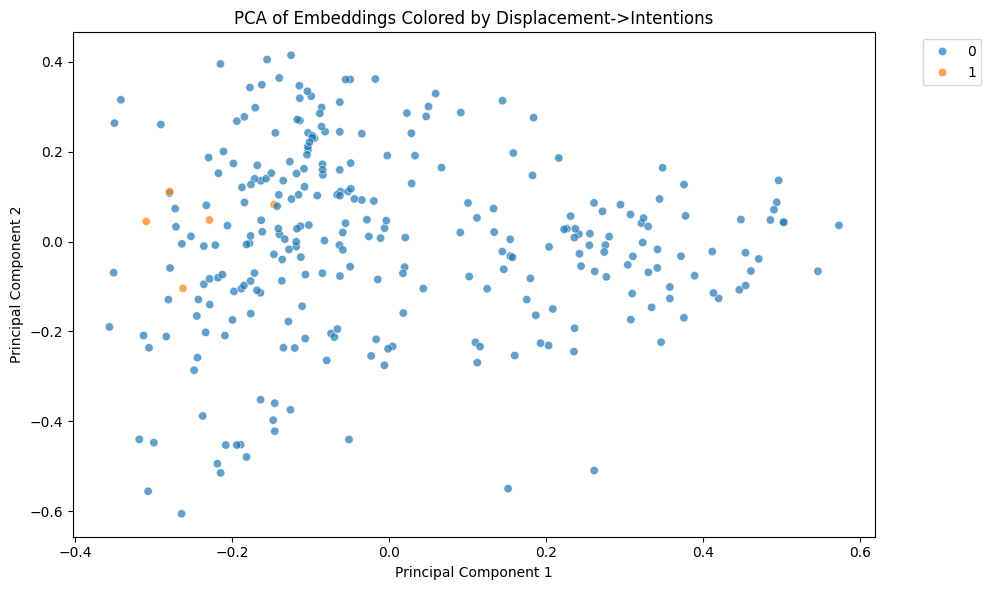

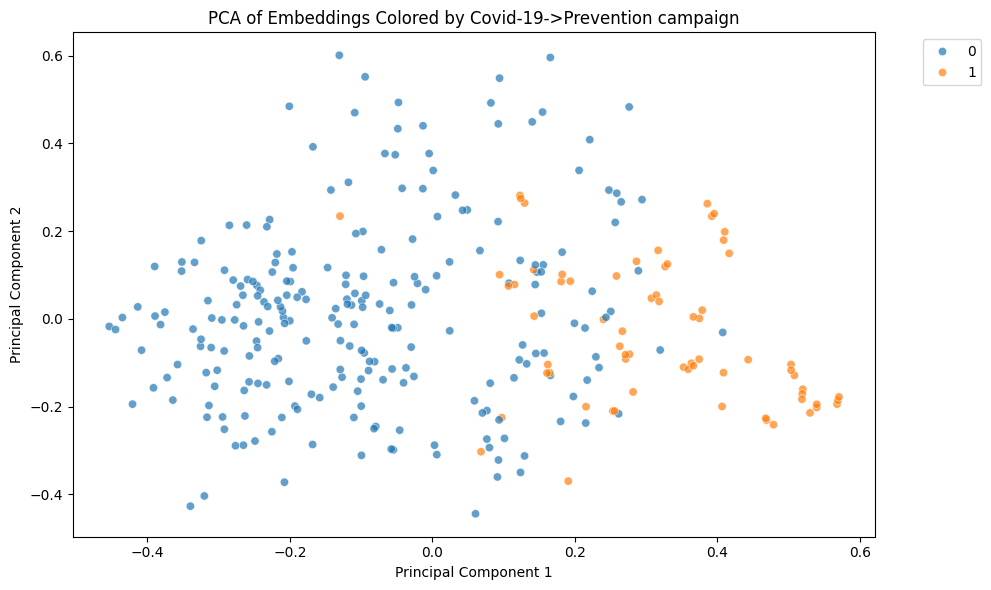

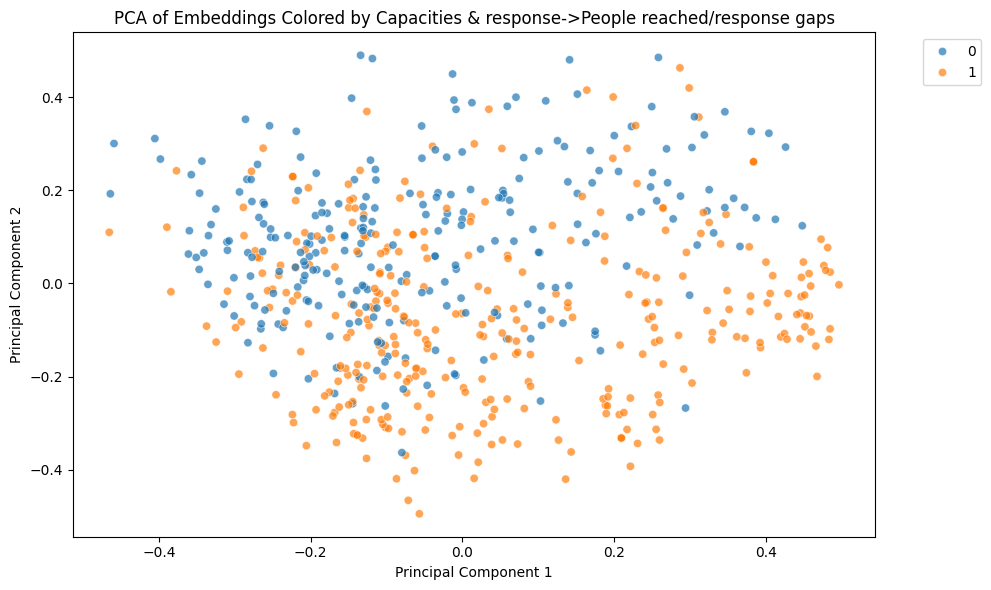

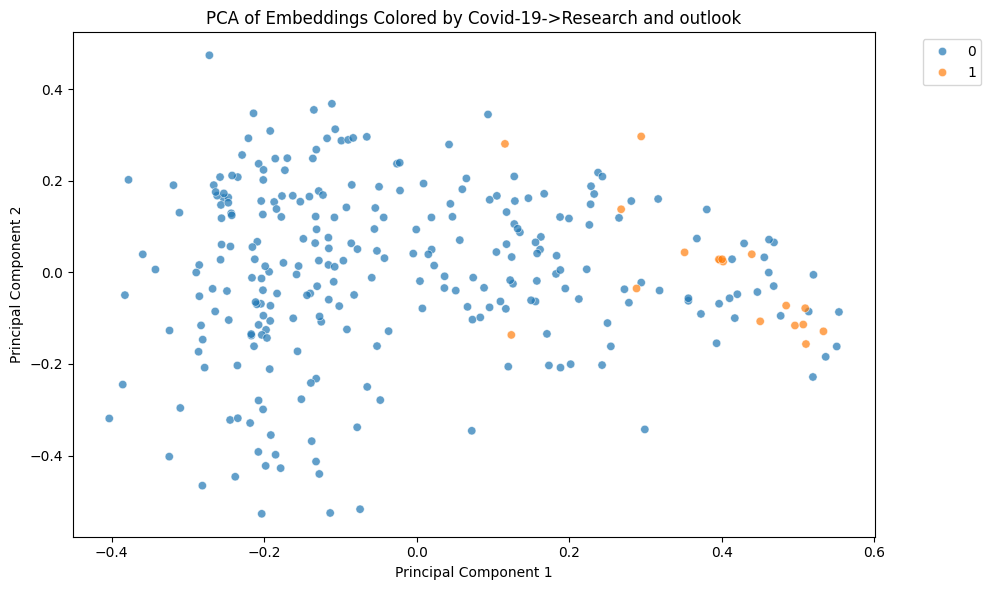

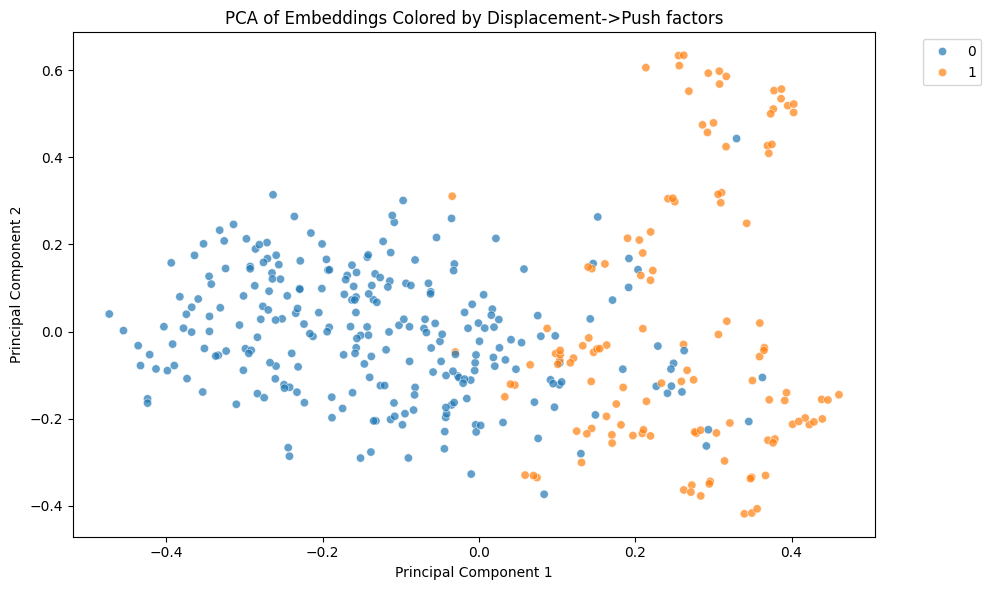

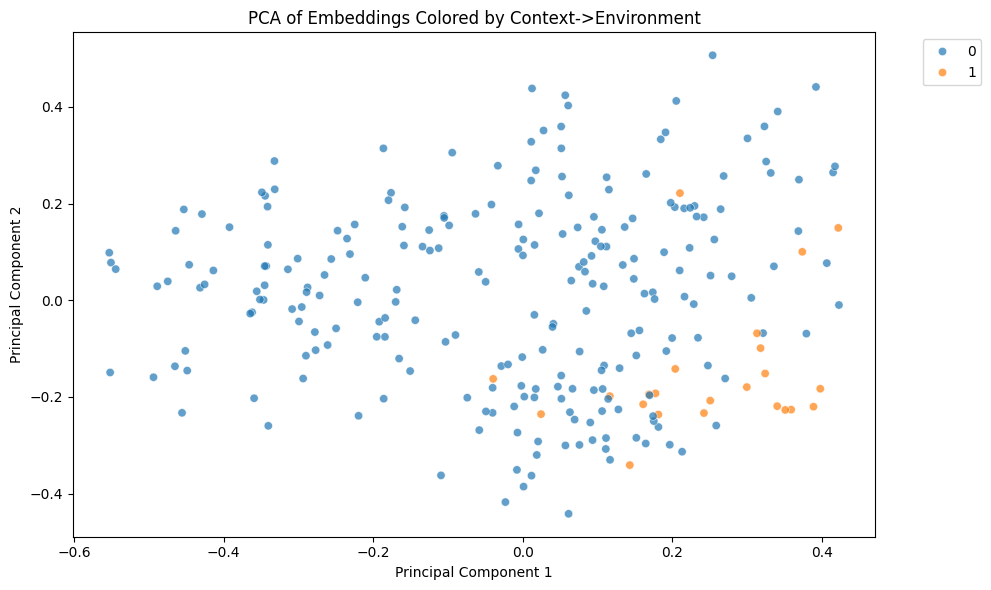

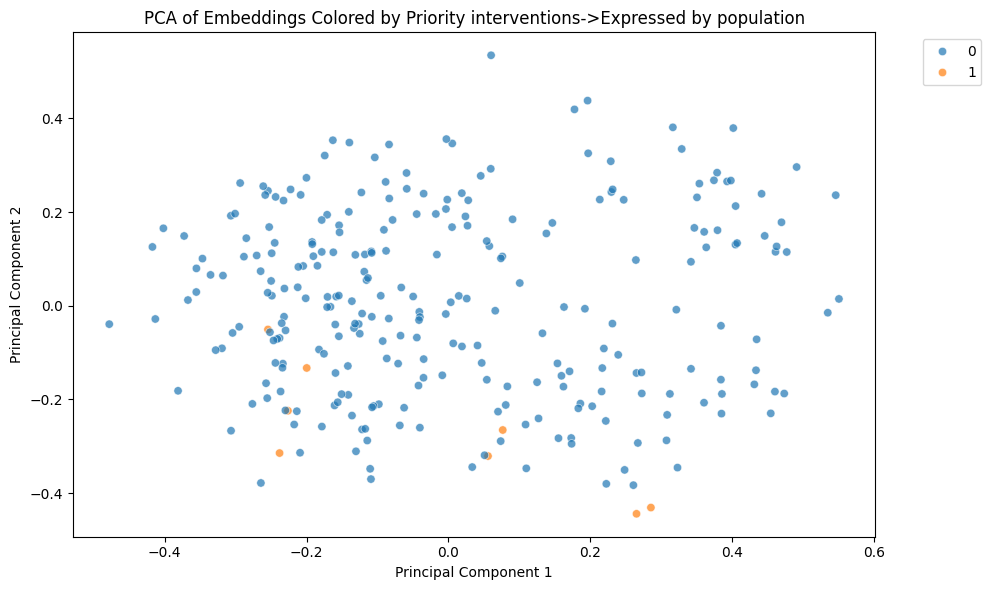

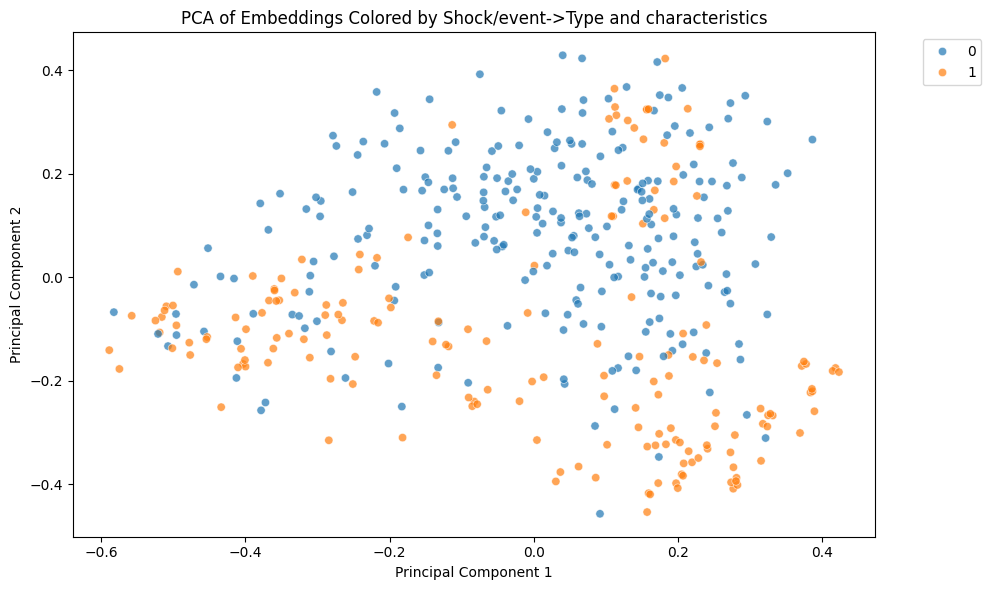

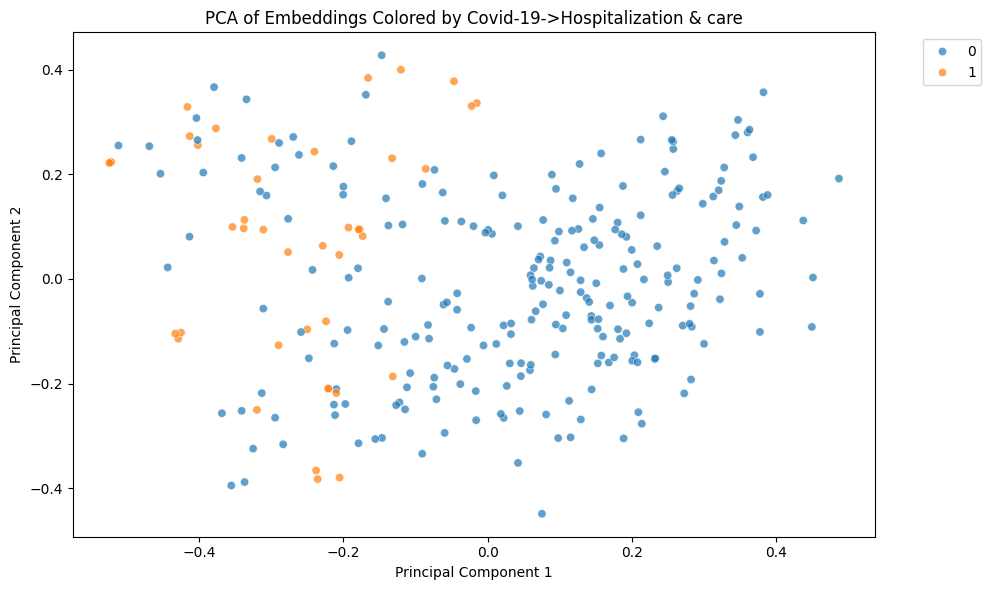

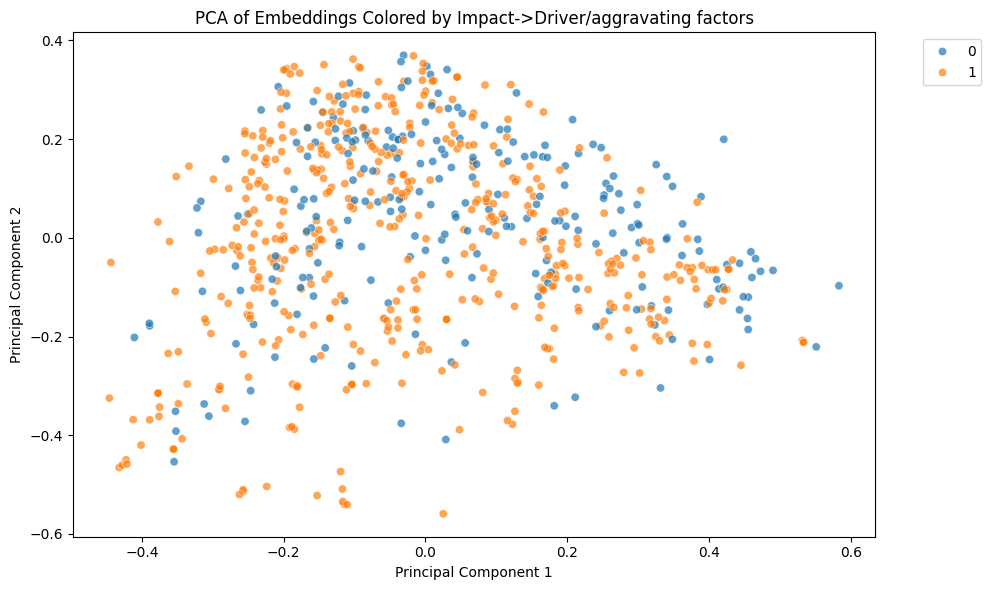

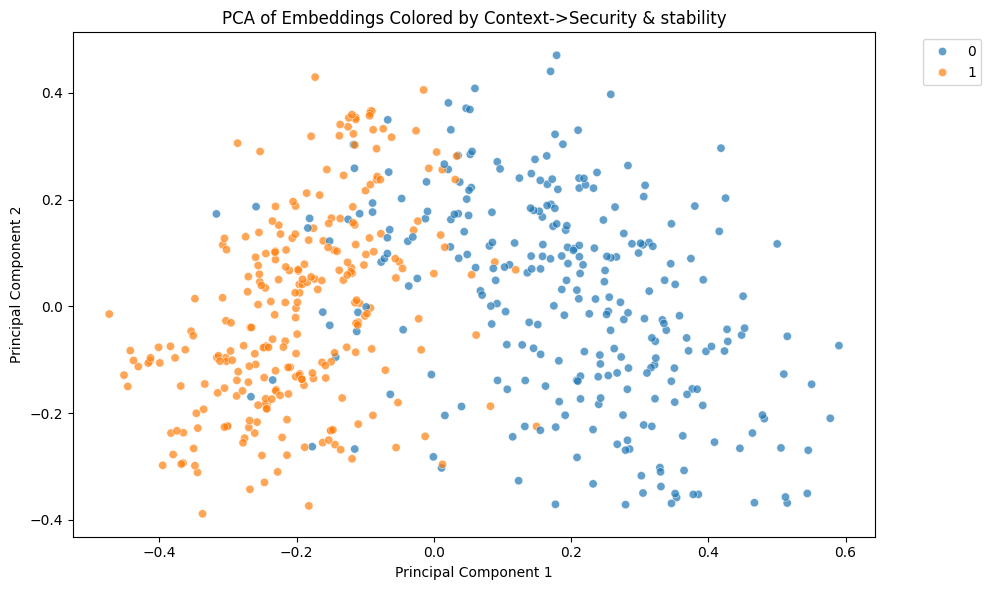

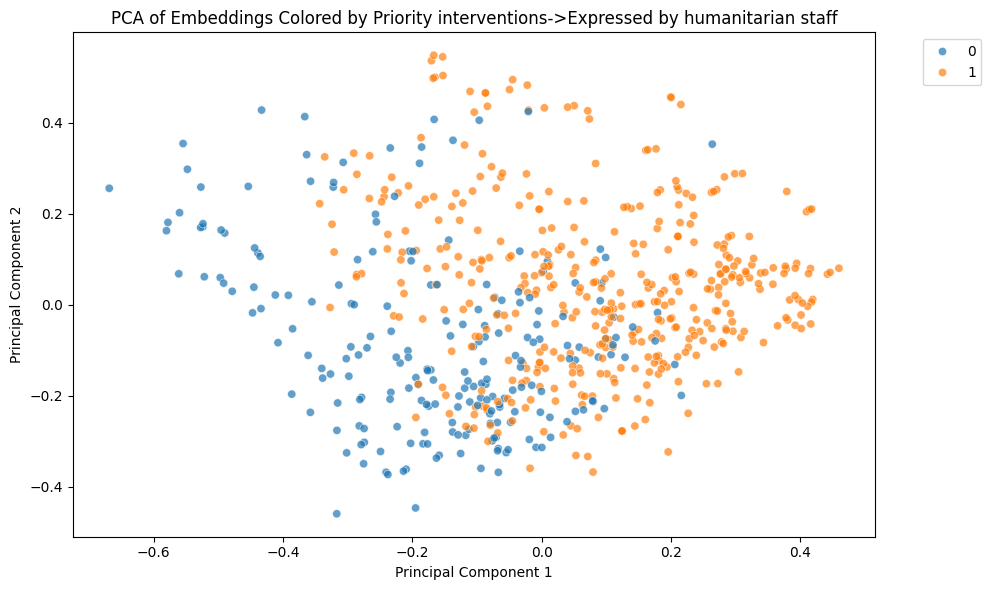

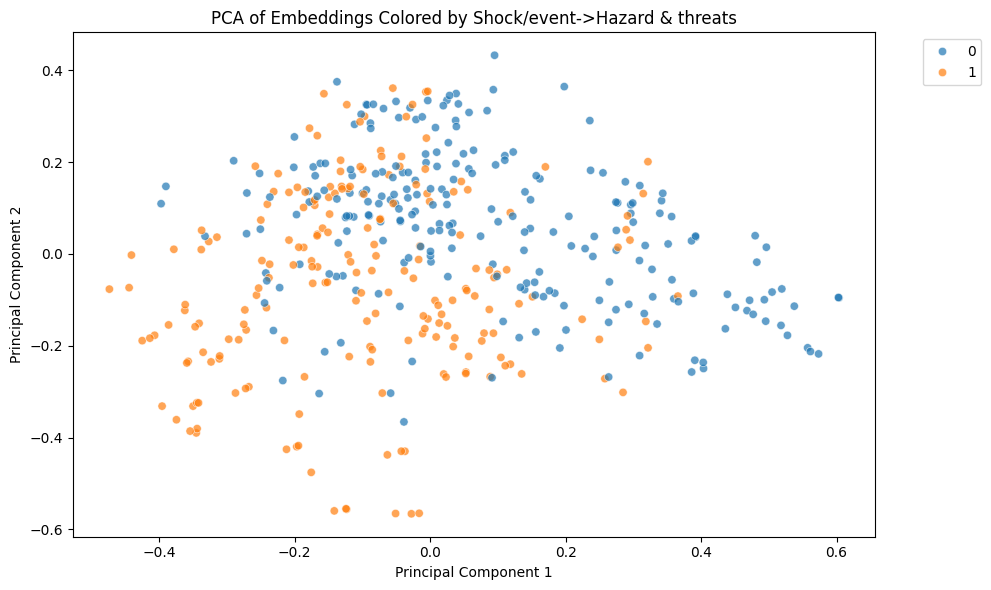

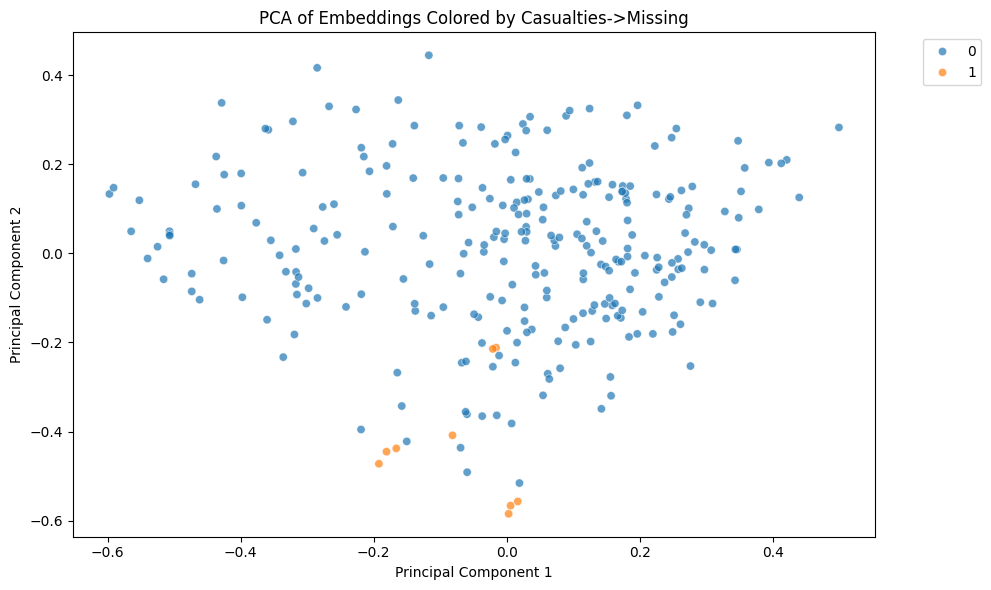

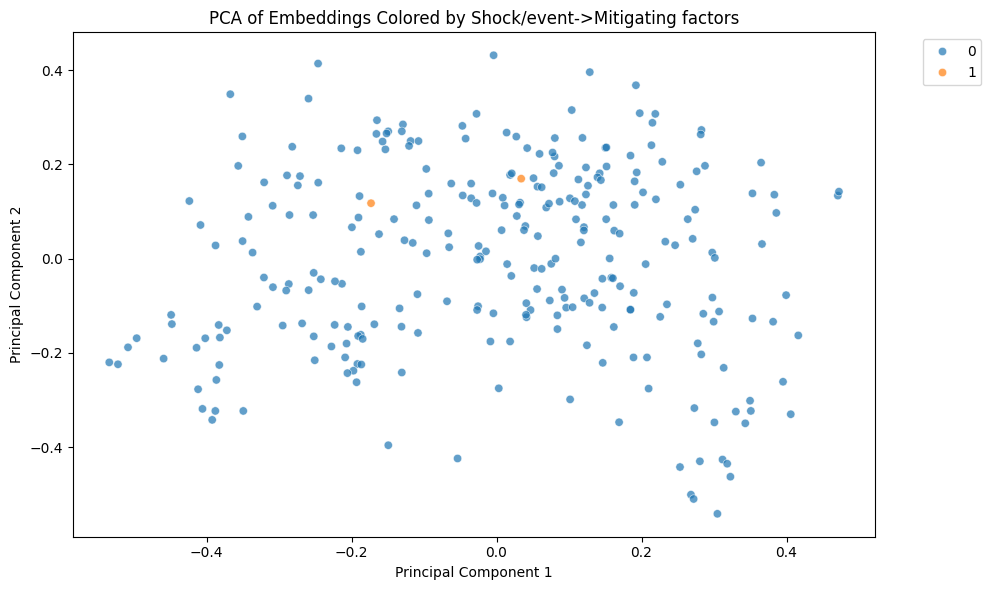

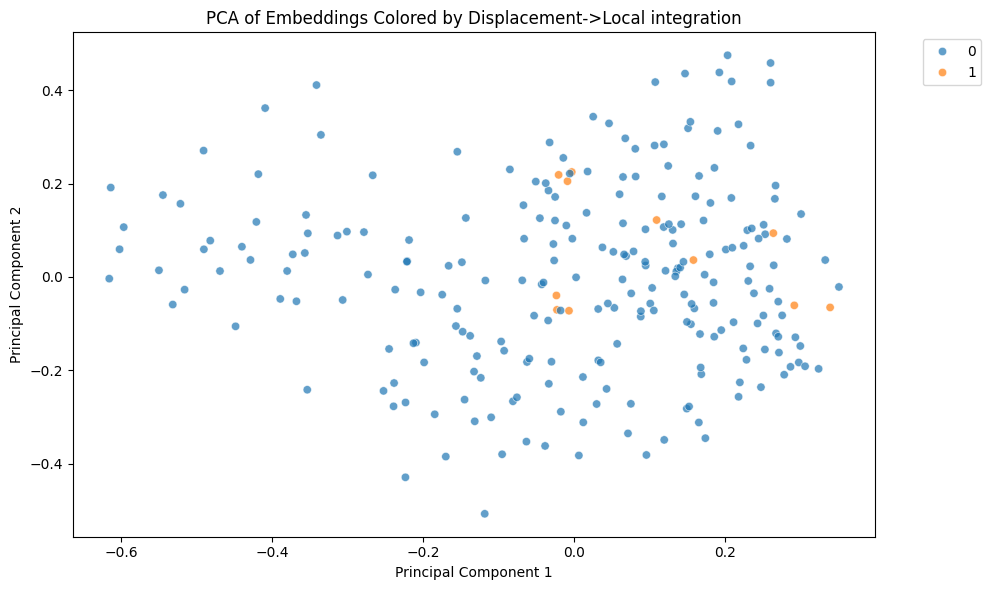

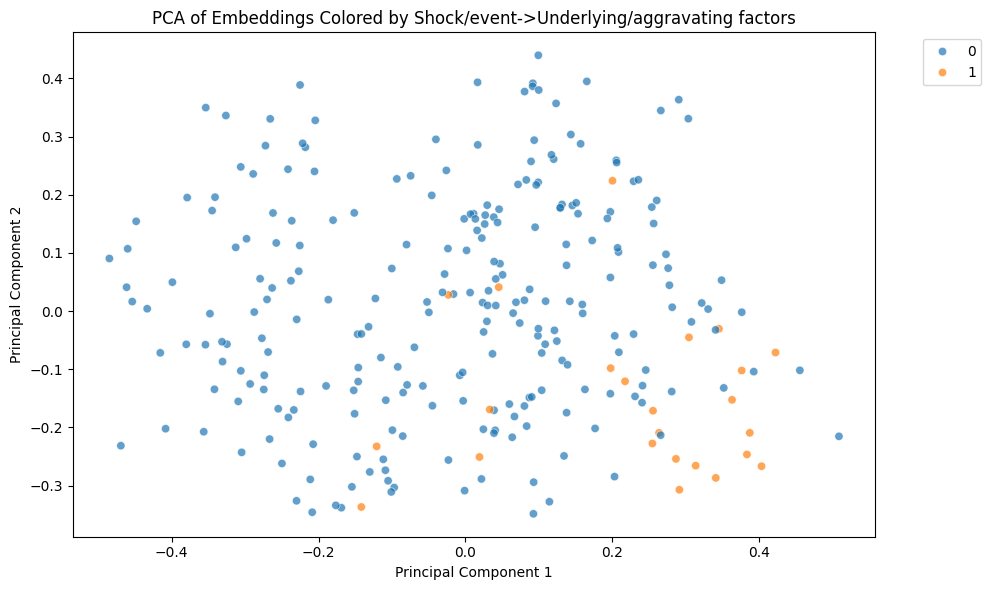

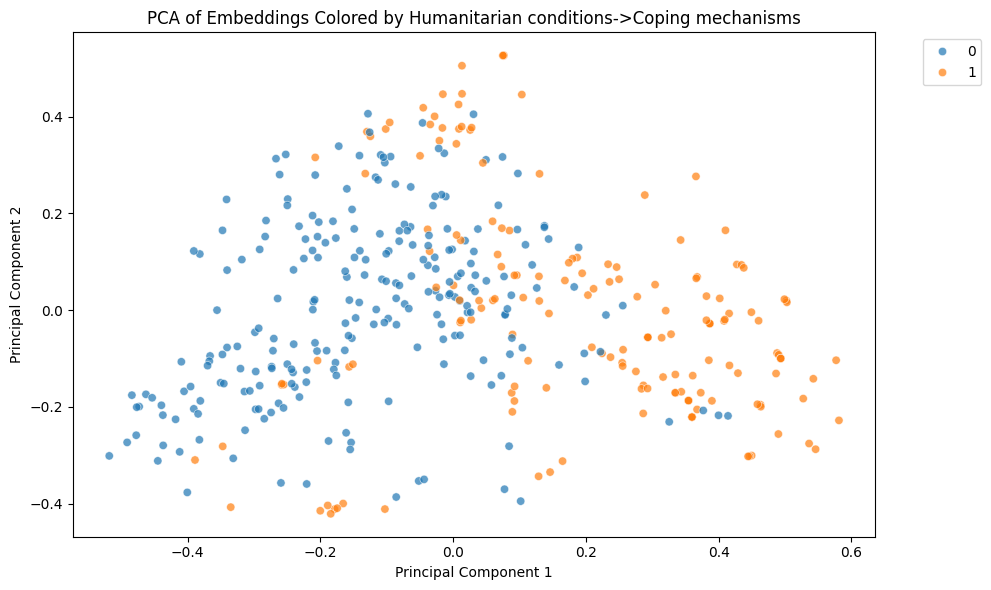

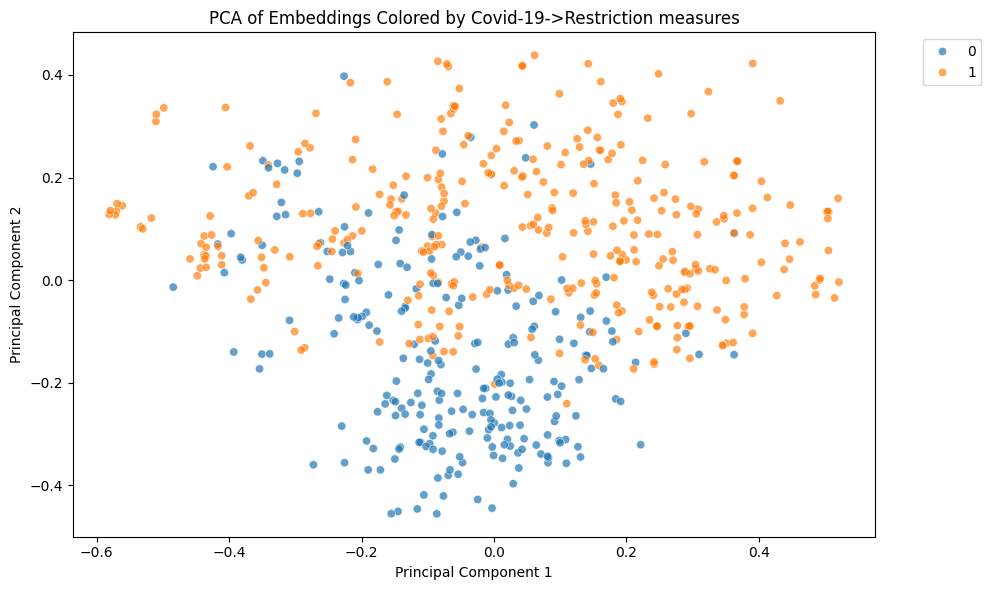

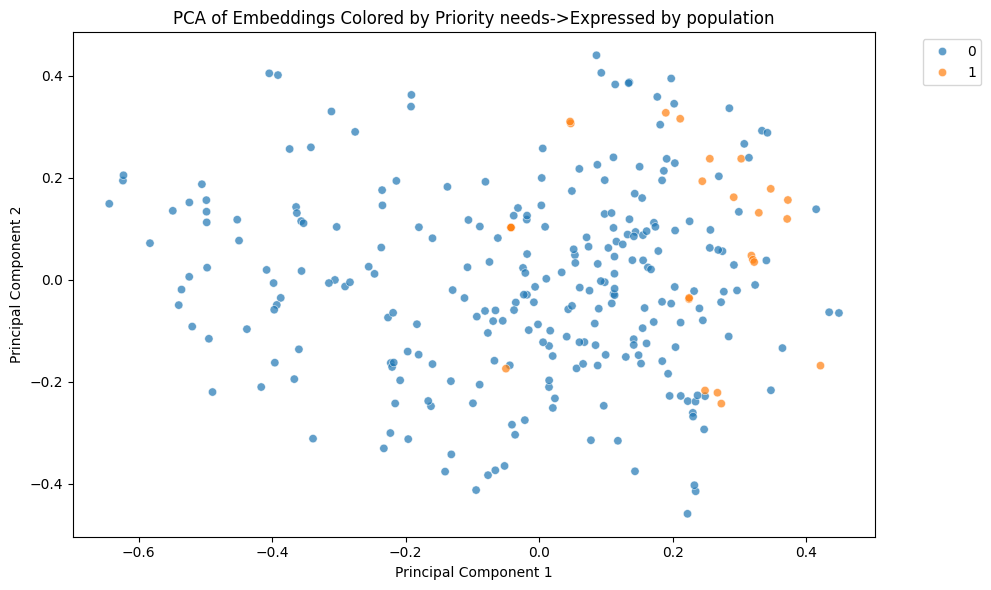

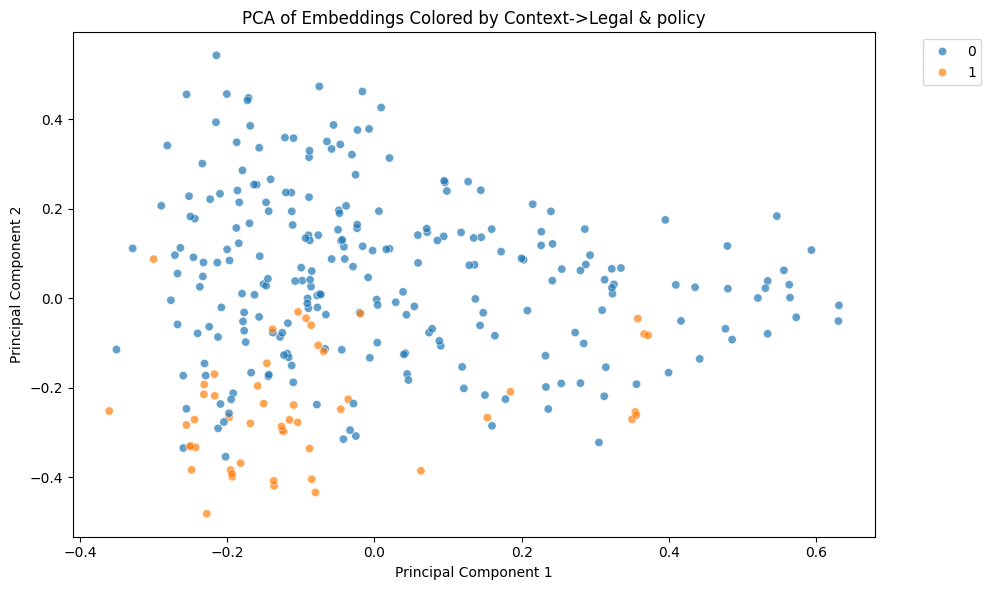

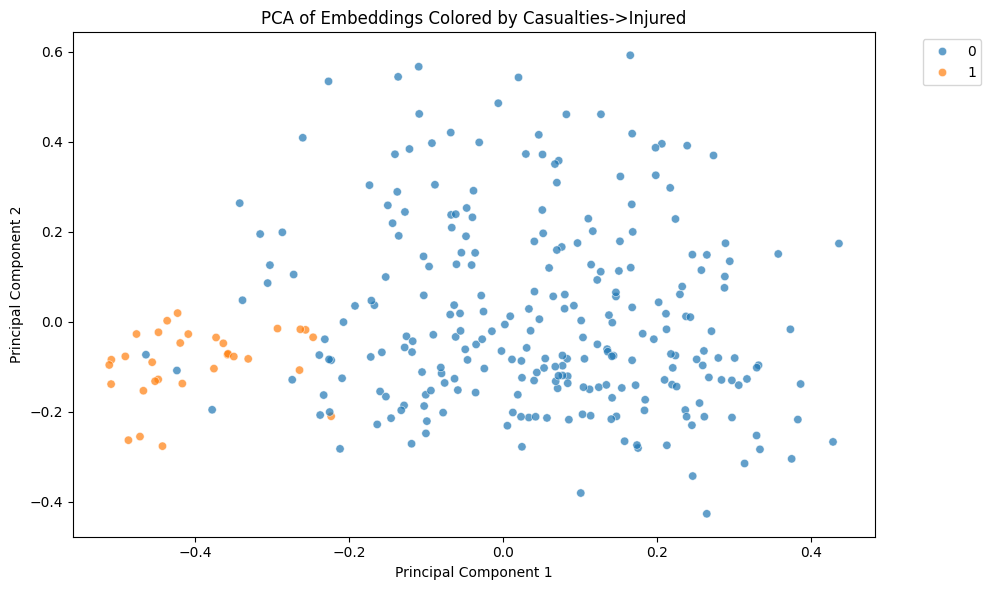

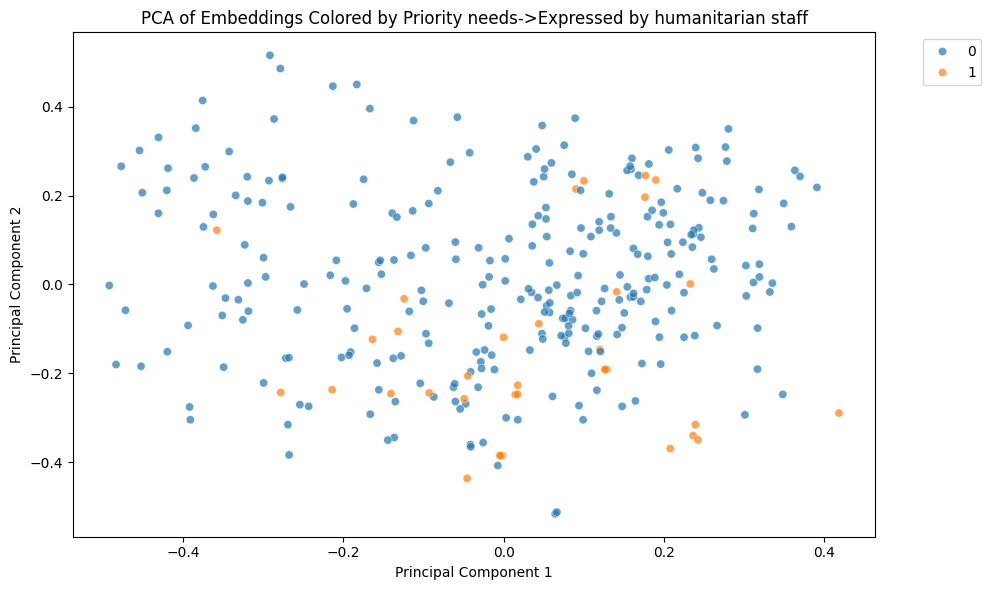

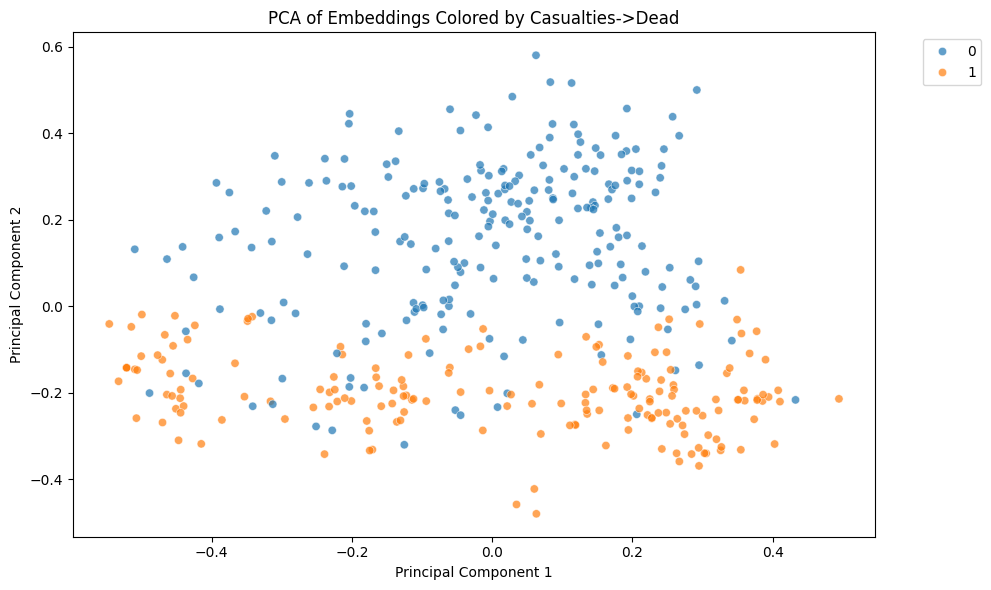

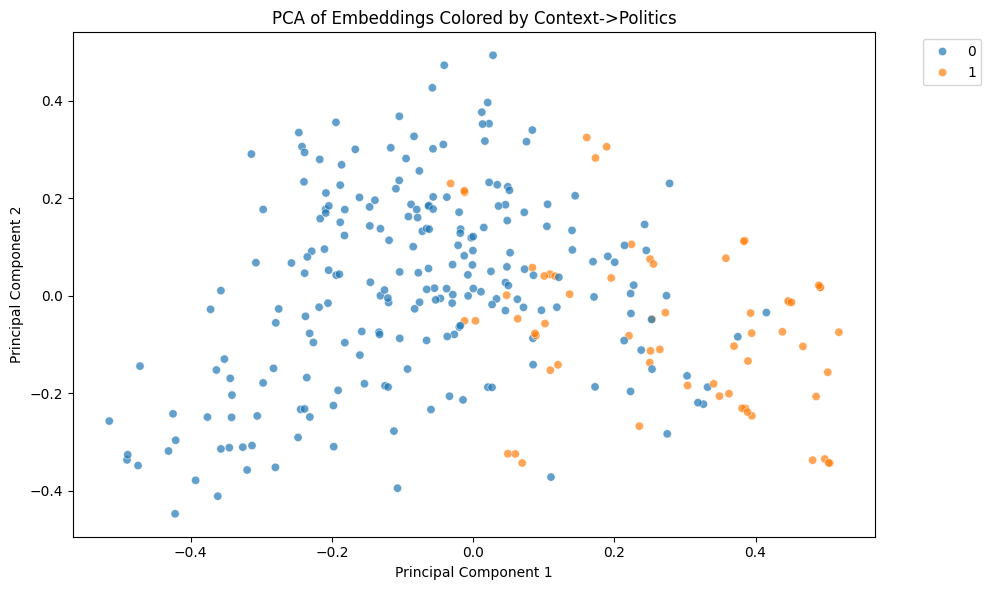

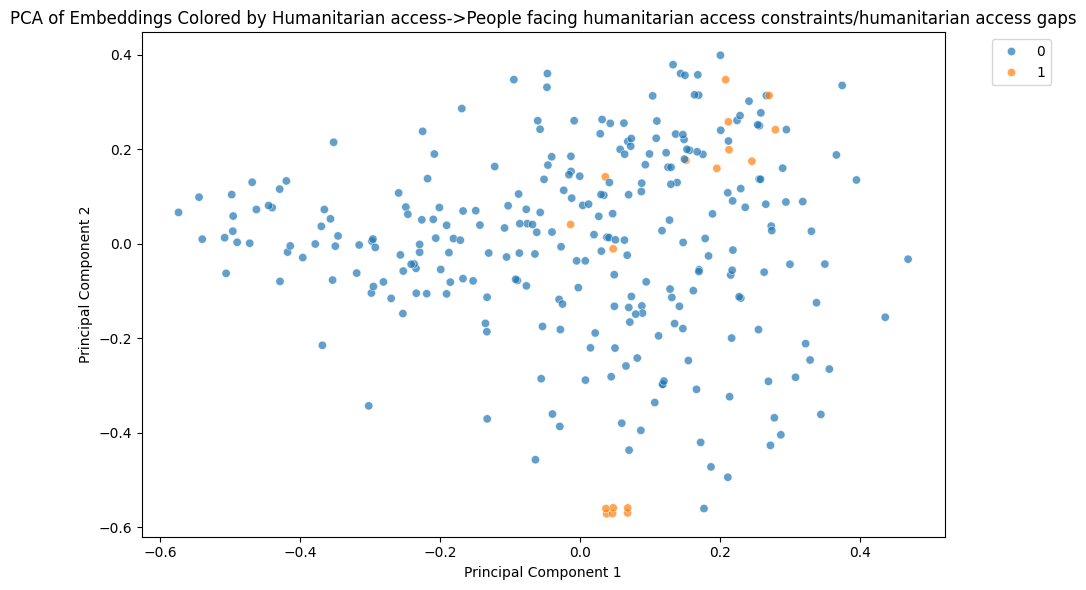

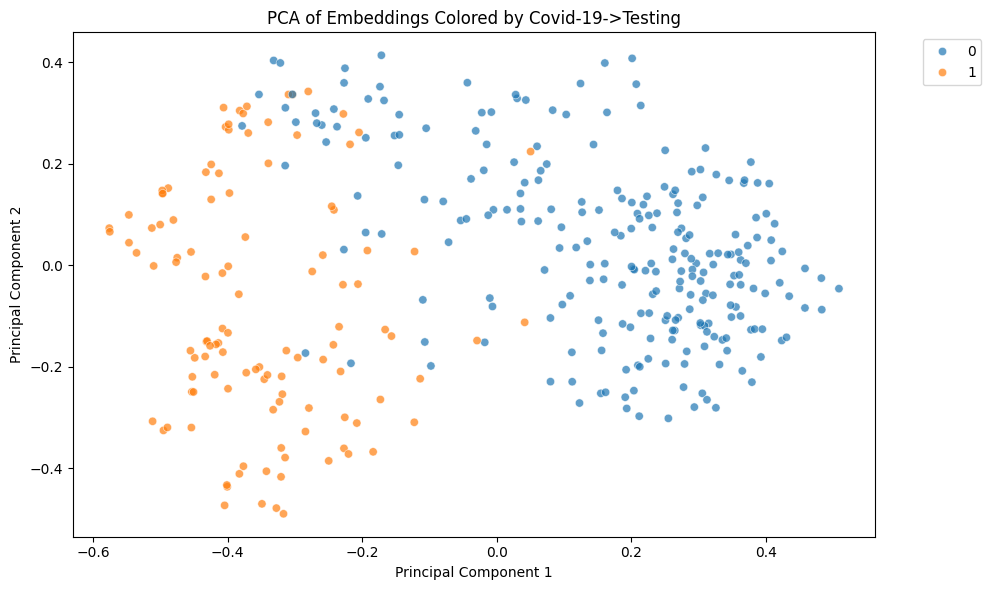

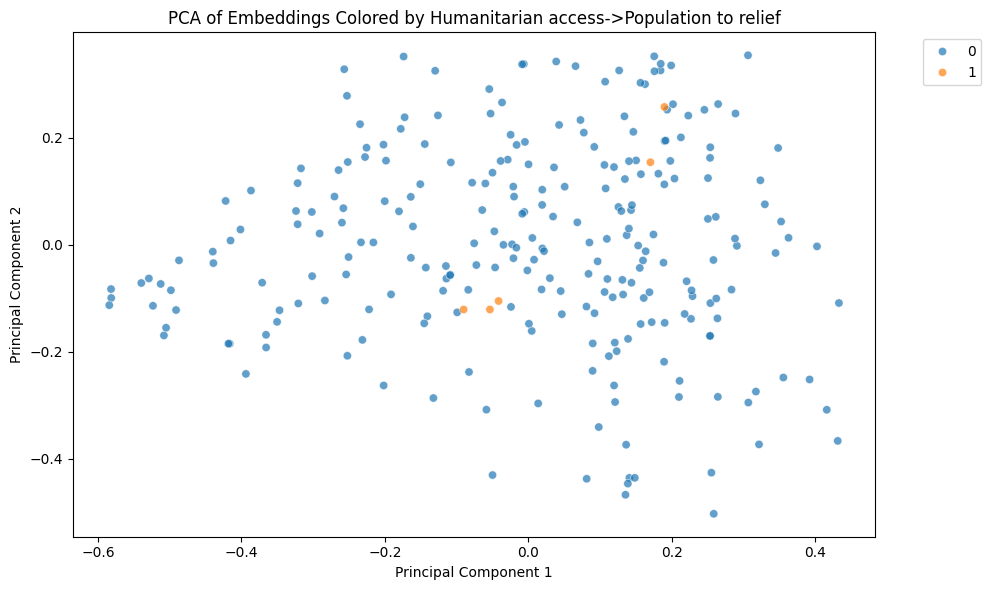

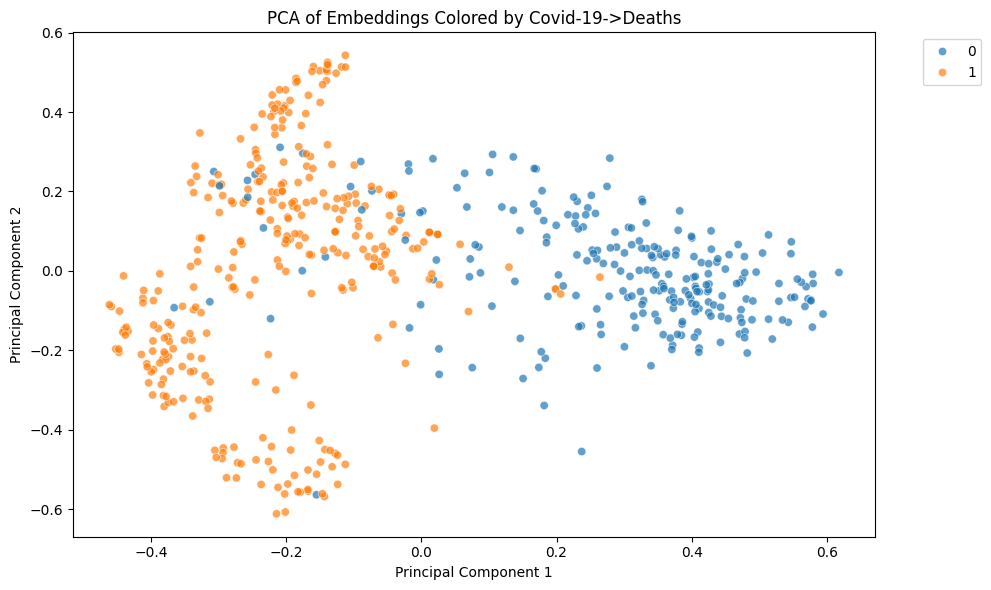

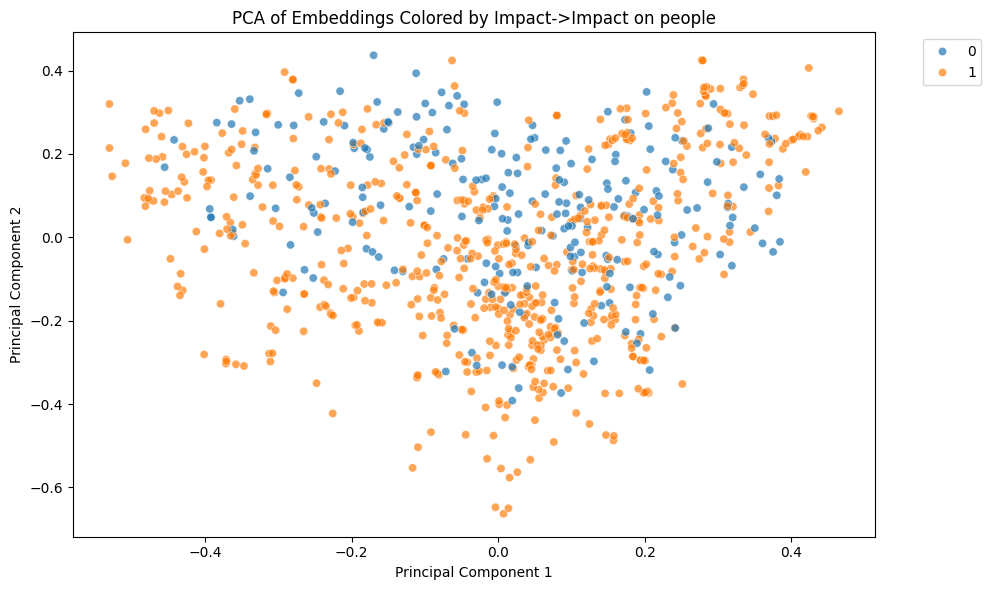

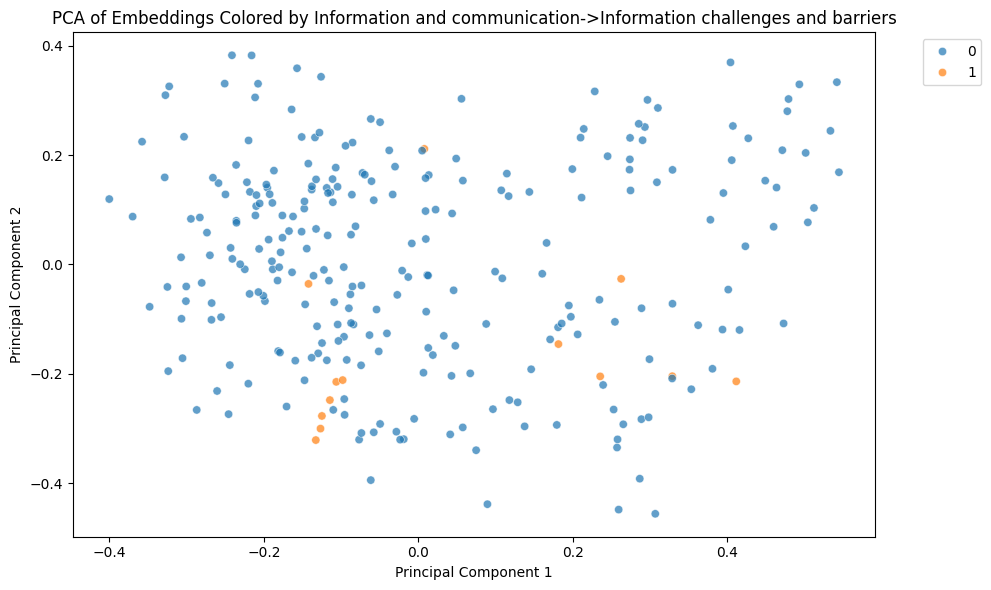

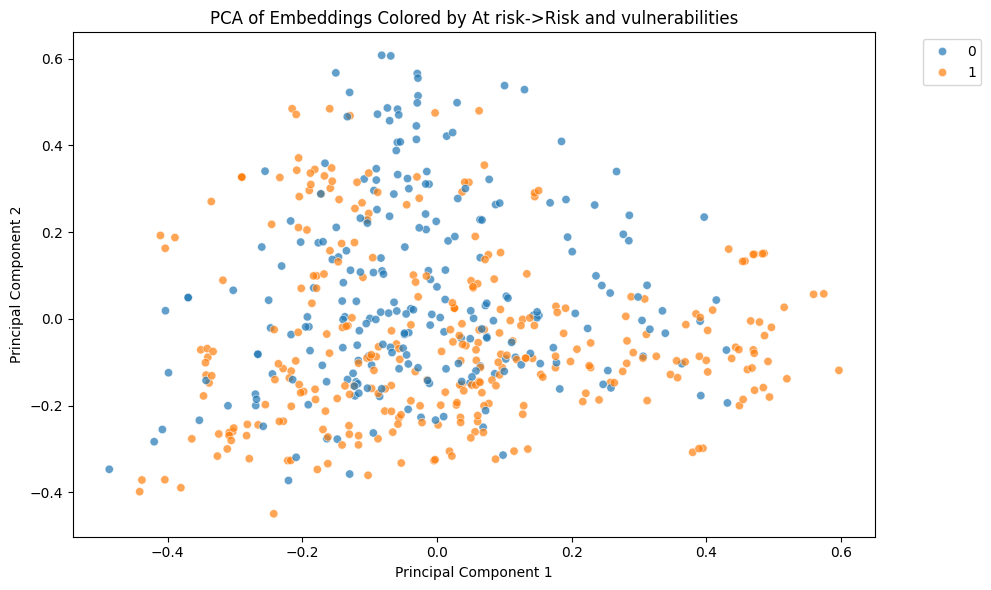

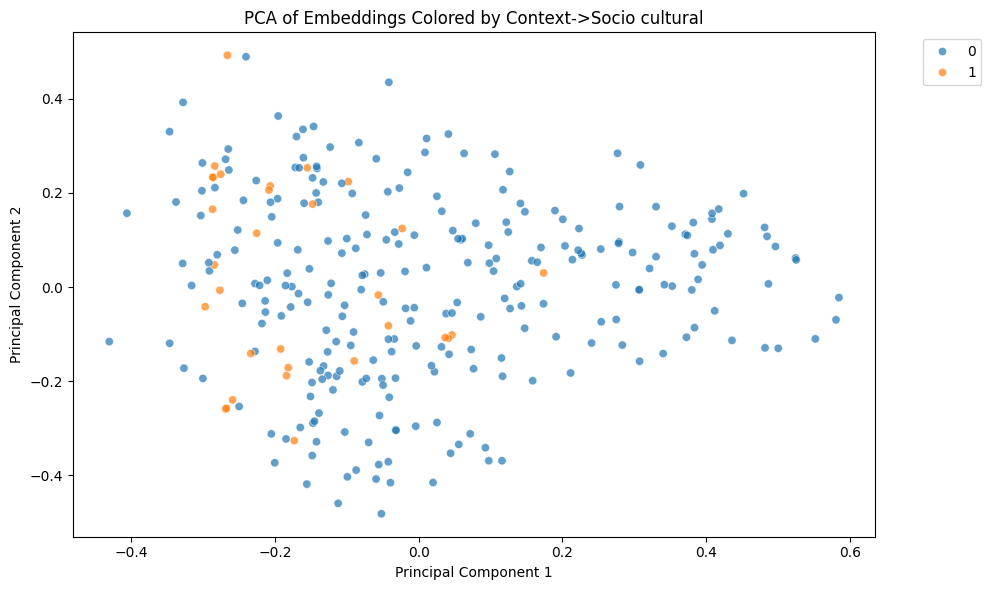

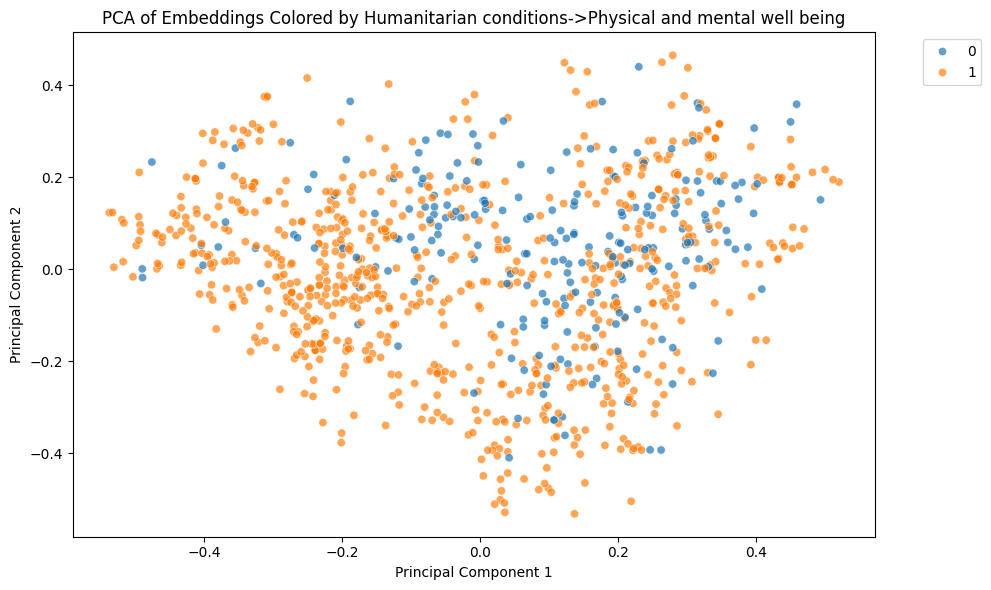

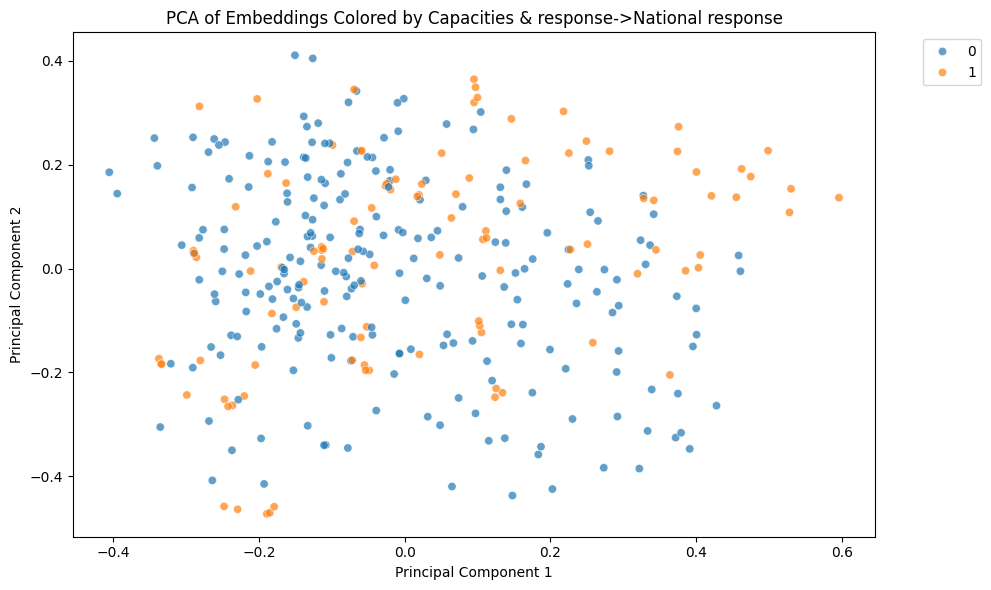

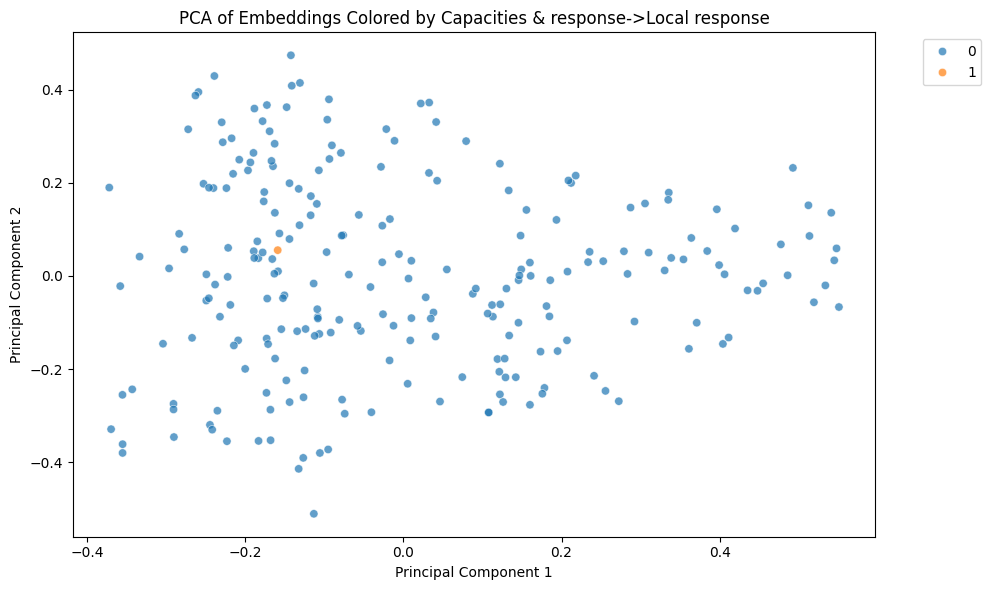

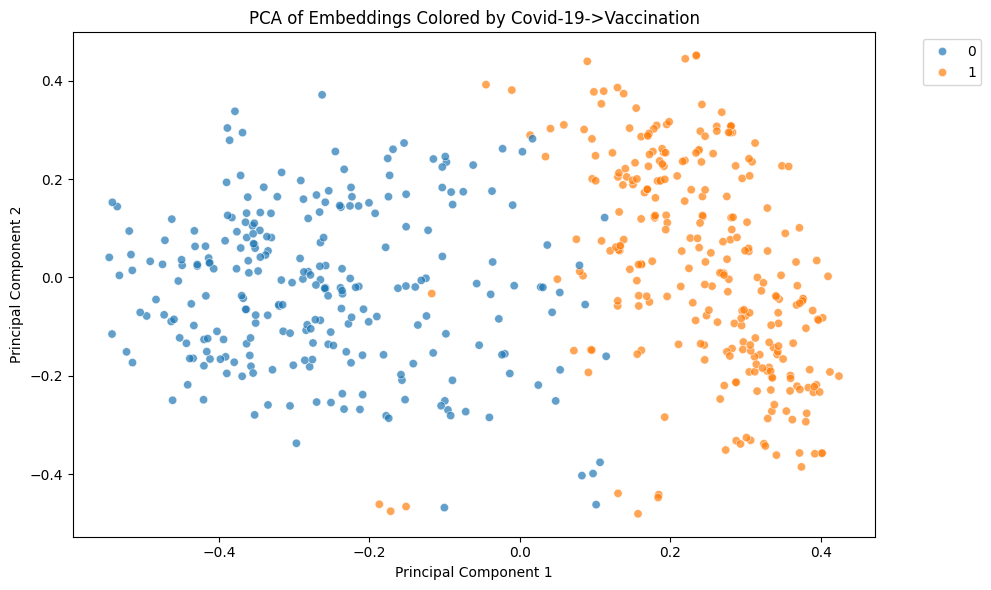

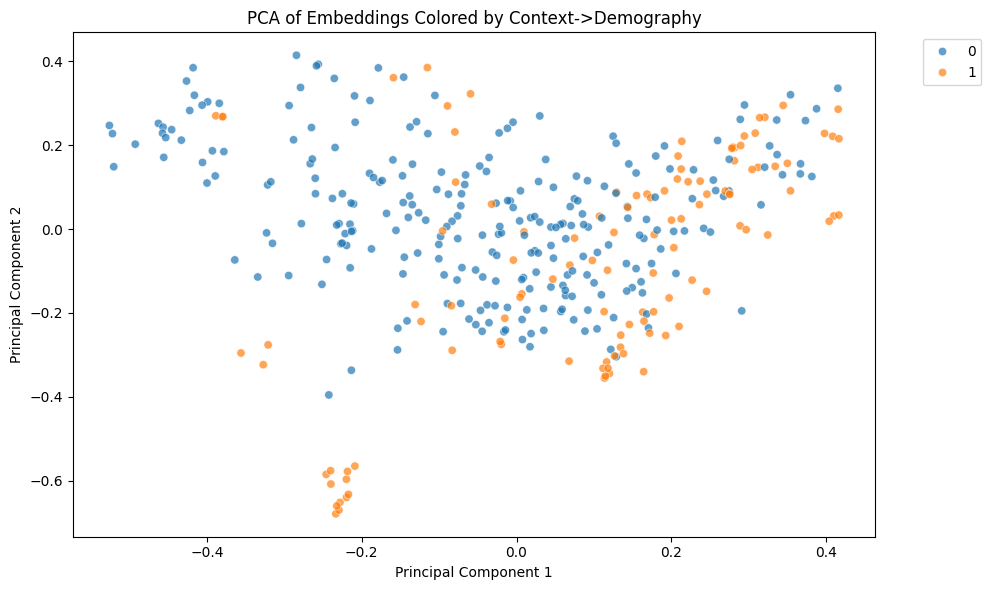

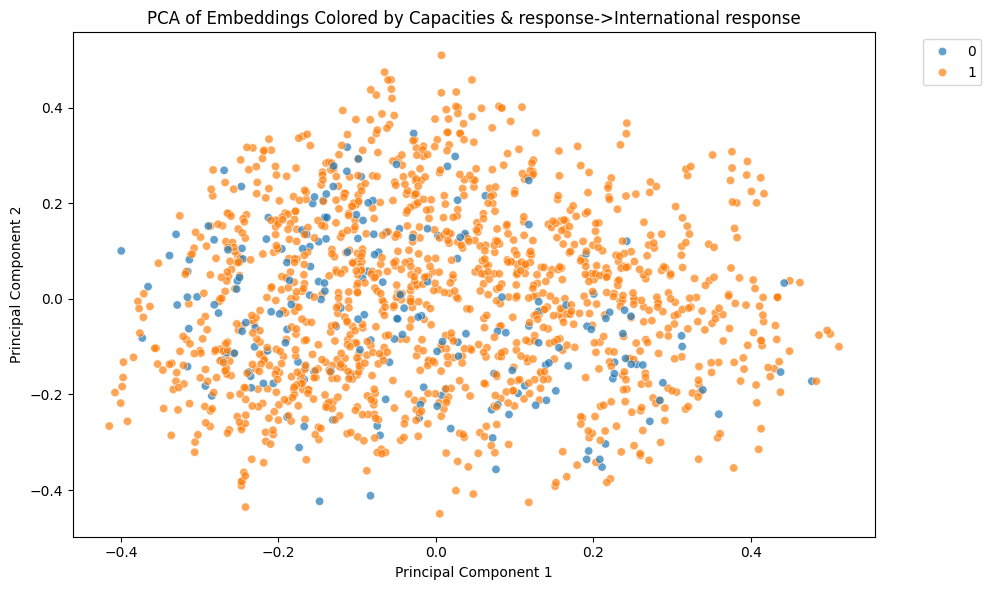

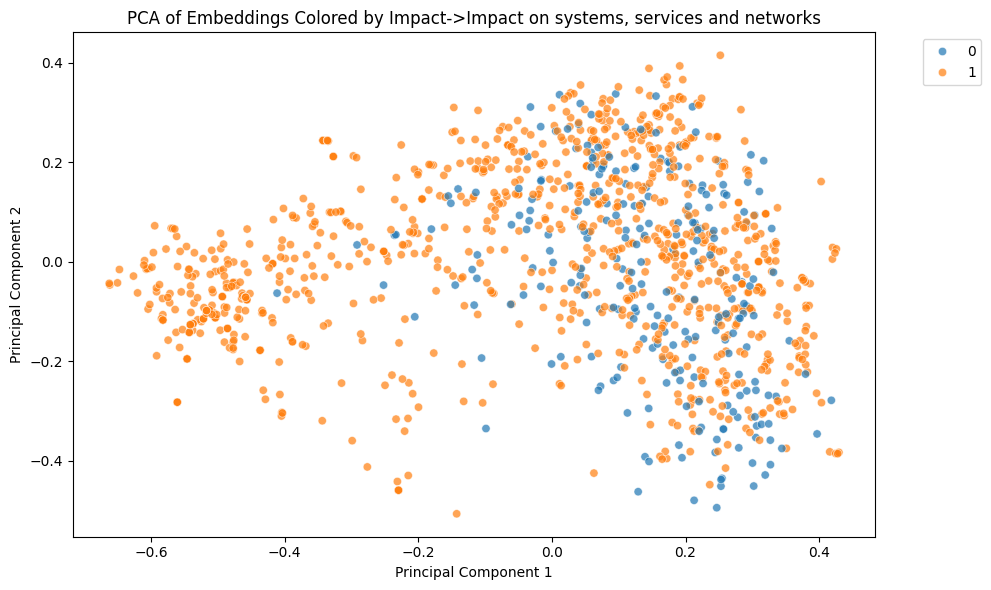

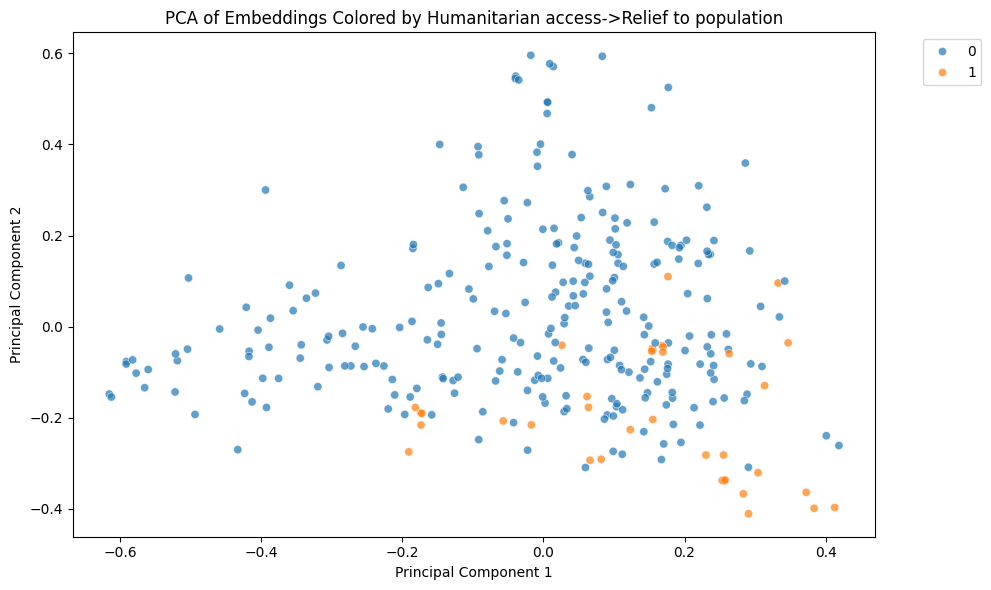

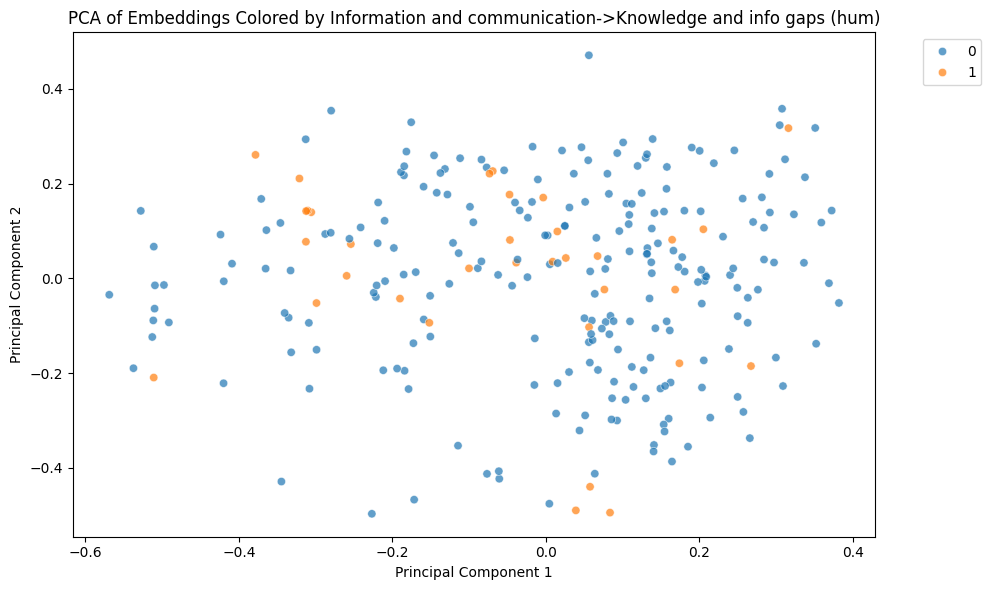

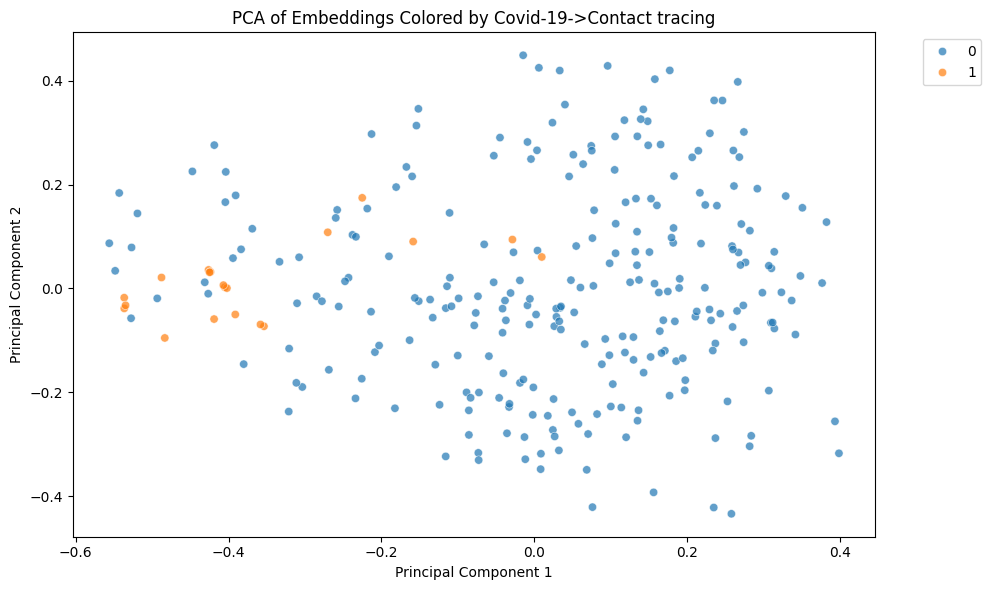

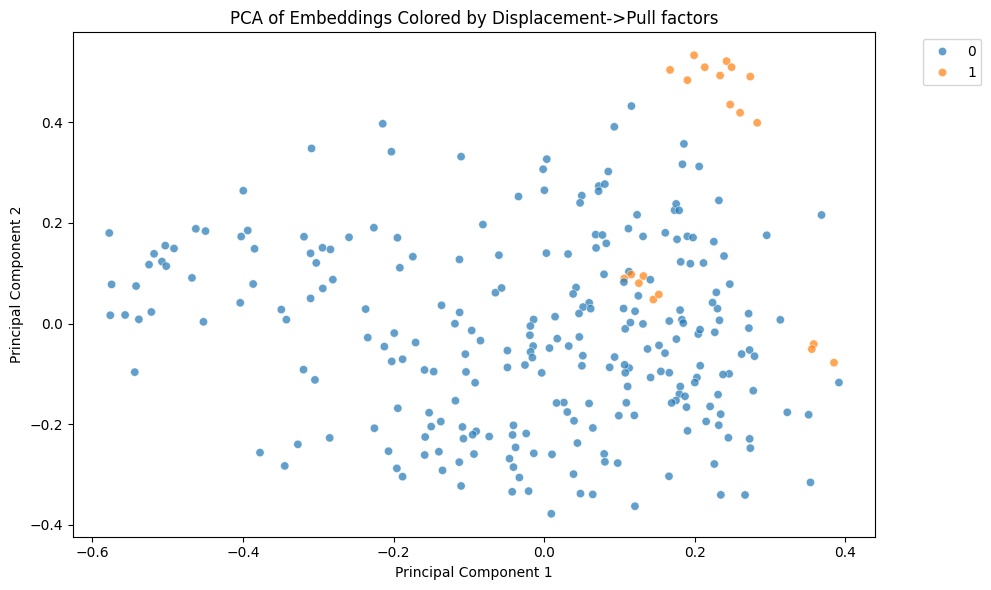

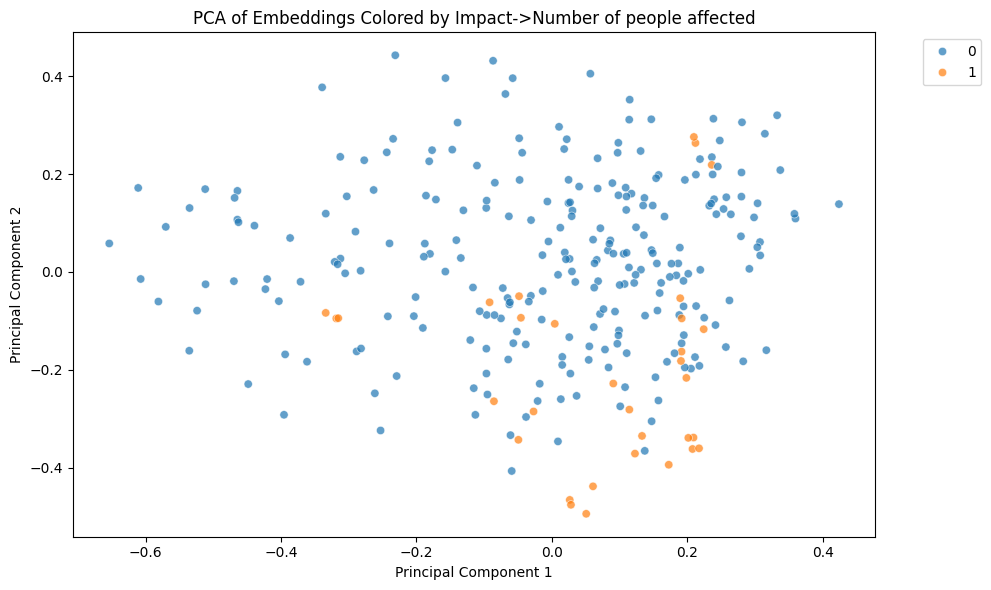

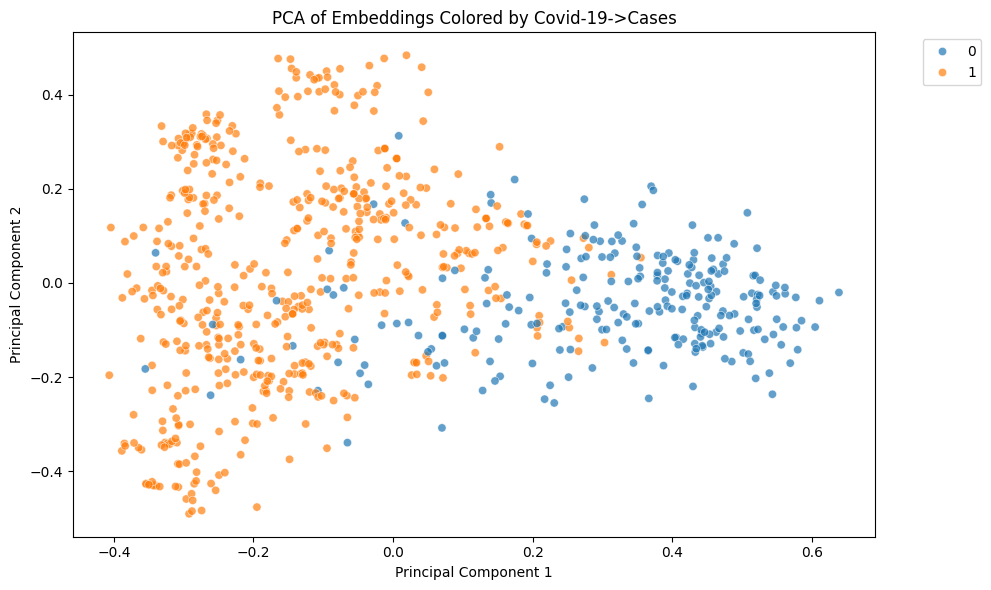

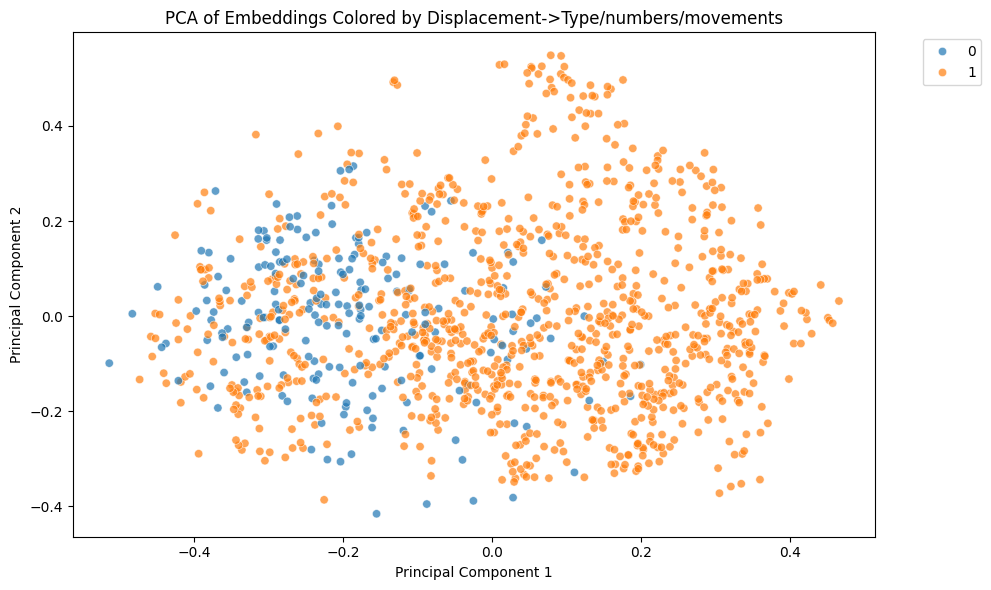

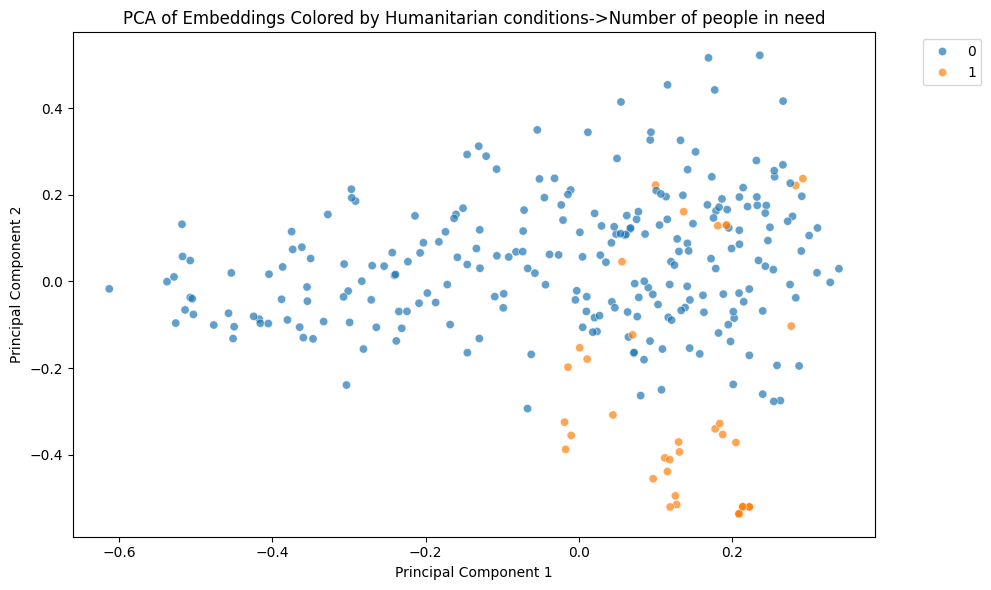

In [ ]:
topics = reduced_binary_df['topic'].values
for i, topic_selected in enumerate(all_topics):

    # Apply PCA to reduce to 2 components for visualization
    pca = PCA(n_components=2)
    X = np.vstack(reduced_binary_df[reduced_binary_df["topic"] == topic_selected]['text_embedding'].values)
    X_pca = pca.fit_transform(X)

    labels = reduced_binary_df[reduced_binary_df["topic"] == topic_selected]['label'].values

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'label': labels
    })

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='label', palette='tab10', alpha=0.7)

    plt.title(f"PCA of Embeddings Colored by {topic_selected}")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()